In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick
import matplotlib.patches as patches
from matplotlib.ticker import FixedLocator
import matplotlib.dates as mdates
import math
import datetime
from UniversalColor import UniversalColor
from SharedX import ShareXaxis
from legend_shadow import legend_shadow

import Leadangle_wave as Wave
from Leadangle_fit_JunoUVS import local_time_moon
from Leadangle_fit_JunoUVS import calc_eqlead
from Leadangle_fit_JunoUVS import Obsresults

import spiceypy as spice
spice.furnsh('kernel/cassMetaK.txt')
savpath = 'data/Satellite_FP_JRM33.sav'

UC = UniversalColor()
UC.set_palette()

Importing Library
done


In [2]:
exdate = '005/20251221'
target_moon = 'Europa'
target_fp = ['MAW', 'TEB']

exnum = ['050', '056']
PJ_list = [6, 10]

In [3]:
def data_load(exname):
    chi2_1d = np.loadtxt('results/fit/'+exname+'/params_chi2.txt')
    Ai_1d = np.loadtxt('results/fit/'+exname+'/params_Ai.txt')
    ni_1d = np.loadtxt('results/fit/'+exname+'/params_ni.txt')
    Ti_1d = np.loadtxt('results/fit/'+exname+'/params_Ti.txt')
    H_1d = np.loadtxt('results/fit/'+exname+'/params_H.txt')
    et_obs = np.loadtxt('results/fit/'+exname+'/et_obs.txt')
    eqlead_obs = np.loadtxt('results/fit/'+exname+'/eqlead_obs.txt')
    eqlead_est = np.loadtxt('results/fit/'+exname+'/eqlead_est.txt')
    moon_s3wlon = np.loadtxt('results/fit/'+exname+'/moon_S3wlon_obs.txt')

    # Reshape the data
    chi2_3d = chi2_1d.reshape(ni_num, Ai_num, Ti_num)
    H_3d = H_1d.reshape(ni_num, Ai_num, Ti_num)
    Ai_3d = Ai_1d.reshape(ni_num, Ai_num, Ti_num)
    ni_3d = ni_1d.reshape(ni_num, Ai_num, Ti_num)
    Ti_3d = Ti_1d.reshape(ni_num, Ai_num, Ti_num)
    chi2_3d = chi2_3d*(eqlead_est.shape[0]-3)

    # print('Parameter ranges:')
    # print('Ai:', np.min(Ai_3d), np.max(Ai_3d))
    # print('ni:', np.min(ni_3d), np.max(ni_3d))
    # print('Ti:', np.min(Ti_3d), np.max(Ti_3d))
    # print('Degree of freedom:', (eqlead_est.shape[0]-3))

    # Search the chi2-minimum
    min_idx = np.where(chi2_3d == np.min(chi2_3d))
    min_idx_Ai = 1
    print('Min chi2:', np.min(chi2_3d), 'at', min_idx)
    print('Scale height [RJ]:', H_3d[min_idx][0]/(71492*1E+3))

    # 1データのヒストグラムを作成する
    Ai_2d = Ai_3d[:, min_idx_Ai, :].T
    ni_2d = ni_3d[:, min_idx_Ai, :].T
    H_2d = H_3d[:, min_idx_Ai, :].T
    Ti_2d = Ti_3d[:, min_idx_Ai, :].T
    chi2_2d = chi2_3d[:, min_idx_Ai, :].T
    column_mass_2da = column_mass_3d[:, min_idx_Ai, :].T
    ftmc_mag_2da = ftmc_mag_3d[:, min_idx_Ai, :].T

    # グリッドの面積比を計算する
    x_grid = ni_2d    # shape -> (Ti.size, ni.size)
    y_grid = Ti_2d
    dx_arr = x_grid[:-1, 1:]-x_grid[:-1, :-1]
    dy_arr = y_grid[1:, :-1]-y_grid[:-1, :-1]

    area = dx_arr * dy_arr
    weight = area/np.max(area)

    # 面積arrayに形状を揃える
    column_mass_2da = column_mass_2da[:-1, :-1]
    chi2_2d = chi2_2d[:-1, :-1]

    # 3-sigma area
    d_chi2 = chi2_2d-np.min(chi2_2d)
    Ai_2d = Ai_2d[np.where(d_chi2 < dchi_3s)]
    ni_2d = ni_2d[np.where(d_chi2 < dchi_3s)]
    H_2d = H_2d[np.where(d_chi2 < dchi_3s)]
    Ti_2d = Ti_2d[np.where(d_chi2 < dchi_3s)]
    column_mass_2da = column_mass_2da[np.where(d_chi2 < dchi_3s)]
    weight = weight[np.where(d_chi2 < dchi_3s)]
    ftmc_mag_2da = ftmc_mag_2da[np.where(d_chi2 < dchi_3s)]
    chi2_2d = chi2_2d[np.where(d_chi2 < dchi_3s)]   # 一番最後に

    chi2_R = np.min(chi2_2d)/(eqlead_est.shape[0]-3)
    # print('chi2_R:', chi2_R)

    # 衛星ローカルタイムをリード角の分だけ補正
    moon_et = np.zeros(et_obs.size)
    for i in range(et_obs.size):
        t0 = spice.et2datetime(et_obs[i])
        omg_syn = 360/Psyn  # [deg/sec]
        tau_A = -eqlead_obs[i]/omg_syn  # Alfven travel time [sec]
        dt = datetime.timedelta(seconds=tau_A)
        moon_et[i] = spice.datetime2et(t0+dt)
    return column_mass_2da, chi2_R, moon_et, Ai_2d, moon_s3wlon, weight

In [4]:
def weighted_percentile(data, weights, perc):
    """
    perc : percentile in [0-1]!
    """
    ix = np.argsort(data)
    data = data[ix]  # sort data
    weights = weights[ix]  # sort weights
    cdf = (np.cumsum(weights) - 0.5 * weights) / \
        np.sum(weights)  # 'like' a CDF function
    return np.interp(perc, cdf, data)

In [5]:
def weighted_boxplot2(ax, x0, quartile1, medians, quartile3,
                      min, max,
                      width=0.03, ec='k', fc='w', lw=1.0):
    # Lower box
    height = medians-quartile1
    patch = patches.Rectangle(xy=(x0-width/2, quartile1),
                              width=width,
                              height=height,
                              ec=ec,
                              lw=lw,
                              fc=fc)
    patch = ax.add_patch(patch)
    patch.set_zorder(2)

    # Upper box
    height = quartile3-medians
    patch = patches.Rectangle(xy=(x0-width/2, medians),
                              width=width,
                              height=height,
                              ec=ec,
                              lw=lw,
                              fc=fc)
    patch = ax.add_patch(patch)
    patch.set_zorder(2)

    # Vertical line
    ax.plot([x0, x0],
            [min,
             max],
            color=ec, linewidth=lw,
            zorder=1)

    # Min
    ax.plot([x0-width/2, x0+width/2],
            [min,
             min],
            color=ec, linewidth=lw,
            zorder=1)

    # Max
    ax.plot([x0-width/2, x0+width/2],
            [max,
             max],
            color=ec, linewidth=lw,
            zorder=1)

    return None

In [6]:
Ai_num = 3
ni_num = 50
Ti_num = 60

# Constants
MU0 = 1.26E-6            # 真空中の透磁率
AMU2KG = 1.66E-27        # 原子質量をkgに変換するファクタ [kg amu^-1]
RJ = 71492E+3            # JUPITER RADIUS [m]
MJ = 1.90E+27            # JUPITER MASS [kg]
C = 2.99792E+8           # LIGHT SPEED [m/s]
G = 6.67E-11             # 万有引力定数  [m^3 kg^-1 s^-2]

Psyn_io = (12.89)*3600      # Moon's synodic period [sec]
Psyn_eu = (11.22)*3600      # Moon's synodic period [sec]
Psyn_ga = (10.53)*3600      # Moon's synodic period [sec]

dchi_1s = 2.30     # デルタchi2の1シグマ区間
dchi_2s = 6.17     # デルタchi2の2シグマ区間
dchi_3s = 11.8     # デルタchi2の3シグマ区間

In [7]:
# Threshold scale height
if target_moon == 'Io':
    Psyn = Psyn_io
    H_thres = 3.0*RJ
    r_moon = 5.9*RJ
elif target_moon == 'Europa':
    Psyn = Psyn_eu
    H_thres = 6.0*RJ
    r_moon = 9.4*RJ
elif target_moon == 'Ganymede':
    Psyn = Psyn_ga
    H_thres = 10.0*RJ
    r_moon = 15.0*RJ

In [8]:
PJ_LIST = [1, 3]+np.arange(4, 43+1, 1).tolist()
if target_moon == 'Io':
    Psyn = Psyn_io
elif target_moon == 'Europa':
    Psyn = Psyn_eu
    PJ_LIST.pop(24-2)
    PJ_LIST.pop(43-3)
elif target_moon == 'Ganymede':
    Psyn = Psyn_ga
    PJ_LIST.pop(24-2)
    PJ_LIST.pop(31-3)
    PJ_LIST.pop(39-4)
    PJ_LIST.pop(43-5)

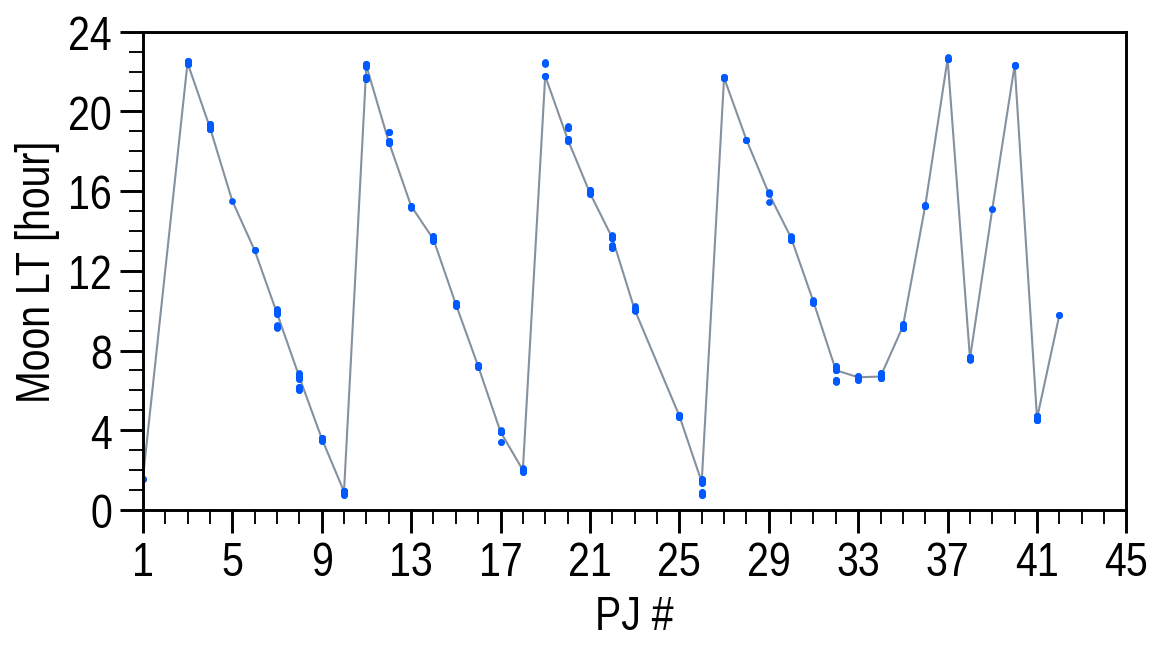

In [9]:
F = ShareXaxis()
F.fontsize = 23
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(8, 4.5), ticksize=1.5,
                dpi='M')
F.initialize()

F.set_xaxis(label='PJ #',
            min=1, max=45,
            ticks=np.arange(1, 45+1, 4),
            ticklabels=np.arange(1, 45+1, 4),
            minor_num=4)
F.set_yaxis(ax_idx=0, label='Moon LT [hour]',
            min=0, max=24,
            ticks=np.arange(0, 24+1, 4),
            ticklabels=np.arange(0, 24+1, 4),
            minor_num=4)

lt_med = np.zeros(len(PJ_LIST))
k = 0
for pj in PJ_LIST:
    wlon_fp, err_wlon_fp, lat_fp, err_lat_fp, moon_S3wlon, et_fp, hem_fp, pj_fp = Obsresults(
        [pj], target_moon, target_fp, TARGET_HEM='both', FLIP=False
    )

    eqlead_fp, eqlead_fp_0, eqlead_fp_1, wlon_TEB_eq = calc_eqlead(wlon_fp,
                                                                   err_wlon_fp,
                                                                   lat_fp,
                                                                   err_lat_fp,
                                                                   hem_fp,
                                                                   moon_S3wlon,
                                                                   target_moon)

    # 衛星ローカルタイムをリード角の分だけ補正
    moon_et = np.zeros(et_fp.size)
    for i in range(et_fp.size):
        t0 = spice.et2datetime(et_fp[i])
        omg_syn = 360/Psyn  # [deg/sec]
        tau_A = -eqlead_fp[i]/omg_syn  # Alfven travel time [sec]
        dt = datetime.timedelta(seconds=tau_A)
        moon_et[i] = spice.datetime2et(t0+dt)

    lt_arr = np.zeros(moon_et.size)
    for i in range(lt_arr.size):
        lt_arr[i] = local_time_moon(moon_et[i], target_moon)
    lt_med[k] = np.median(lt_arr)
    k += 1

    F.ax.scatter(pj*np.ones(lt_arr.size), lt_arr, s=5.0, color=UC.blue)

F.ax.plot(PJ_LIST, lt_med, color=UC.gray, linewidth=1.0, zorder=0.5)

In [10]:
pos_moon, _ = spice.spkpos(
    targ=target_moon, et=moon_et[0], ref='JUNO_JSS', abcorr='None', obs='JUPITER'
)

print(pos_moon/71492)
print(np.sqrt(pos_moon[0]**2+pos_moon[1]**2+pos_moon[2]**2)/71492)

LT = 24.0*np.arctan2(pos_moon[1], pos_moon[0])/(2*np.pi) + 12.0

[ 7.92025197 -5.19467325 -0.04981796]
9.471932397871225


In [11]:
def local_time_moon2(et: float, MOON: str, abcorr='none'):
    # Moon's position seen from Jupiter in IAU_JUPITER coordinate.
    pos_moon, _ = spice.spkpos(
        targ=MOON, et=et, ref='JUNO_JSS', abcorr=abcorr, obs='JUPITER'
    )

    # X axis pointing toward the Sun
    x_moon = pos_moon[0]*1E+3
    y_moon = pos_moon[1]*1E+3
    z_moon = pos_moon[2]*1E+3

    r_moon = np.sqrt(x_moon**2 + y_moon**2 + z_moon**2)
    theta_moon = np.arccos(z_moon/r_moon)
    phi_moon = np.arctan2(y_moon, x_moon)

    local_time = (24.0*phi_moon)/(2*np.pi) + 12.0   # [hour]

    return local_time

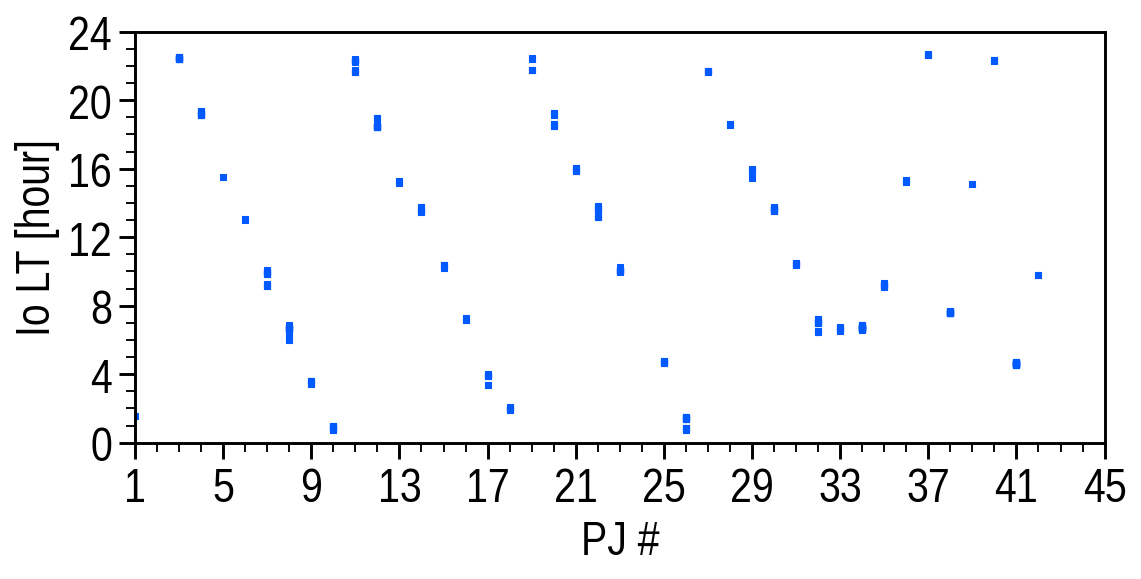

In [12]:
F = ShareXaxis()
F.fontsize = 23
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(8, 4),
                dpi='M')
F.initialize()

F.set_xaxis(label='PJ #',
            min=1, max=45,
            ticks=np.arange(1, 45+1, 4),
            ticklabels=np.arange(1, 45+1, 4),
            minor_num=4)
F.set_yaxis(ax_idx=0, label='Io LT [hour]',
            min=0, max=24,
            ticks=np.arange(0, 24+1, 4),
            ticklabels=np.arange(0, 24+1, 4),
            minor_num=4)

lt_med = np.zeros(len(PJ_LIST))
k = 0
for pj in PJ_LIST:
    wlon_fp, err_wlon_fp, lat_fp, err_lat_fp, moon_S3wlon, et_fp, hem_fp, pj_fp = Obsresults(
        [pj], target_moon, target_fp, TARGET_HEM='both', FLIP=False
    )

    eqlead_fp, eqlead_fp_0, eqlead_fp_1, wlon_TEB_eq = calc_eqlead(wlon_fp,
                                                                   err_wlon_fp,
                                                                   lat_fp,
                                                                   err_lat_fp,
                                                                   hem_fp,
                                                                   moon_S3wlon,
                                                                   target_moon)

    # 衛星ローカルタイムをリード角の分だけ補正
    moon_et = np.zeros(et_fp.size)
    for i in range(et_fp.size):
        t0 = spice.et2datetime(et_fp[i])
        omg_syn = 360/Psyn  # [deg/sec]
        tau_A = -eqlead_fp[i]/omg_syn  # Alfven travel time [sec]
        dt = datetime.timedelta(seconds=tau_A)
        moon_et[i] = spice.datetime2et(t0+dt)

    lt_arr = np.zeros(moon_et.size)
    for i in range(lt_arr.size):
        lt_arr[i] = local_time_moon2(moon_et[i], target_moon)
    lt_med[k] = np.median(lt_arr)
    k += 1

    F.ax.scatter(pj*np.ones(lt_arr.size), lt_arr,
                 s=9.0, marker='s', color=UC.blue,
                 linewidth=0.5)

# F.ax.plot(PJ_LIST, lt_med, color=UC.blue, linewidth=2.0, zorder=0.5)

time format 0
ax idx: 0
ax idx: 1
time format 1


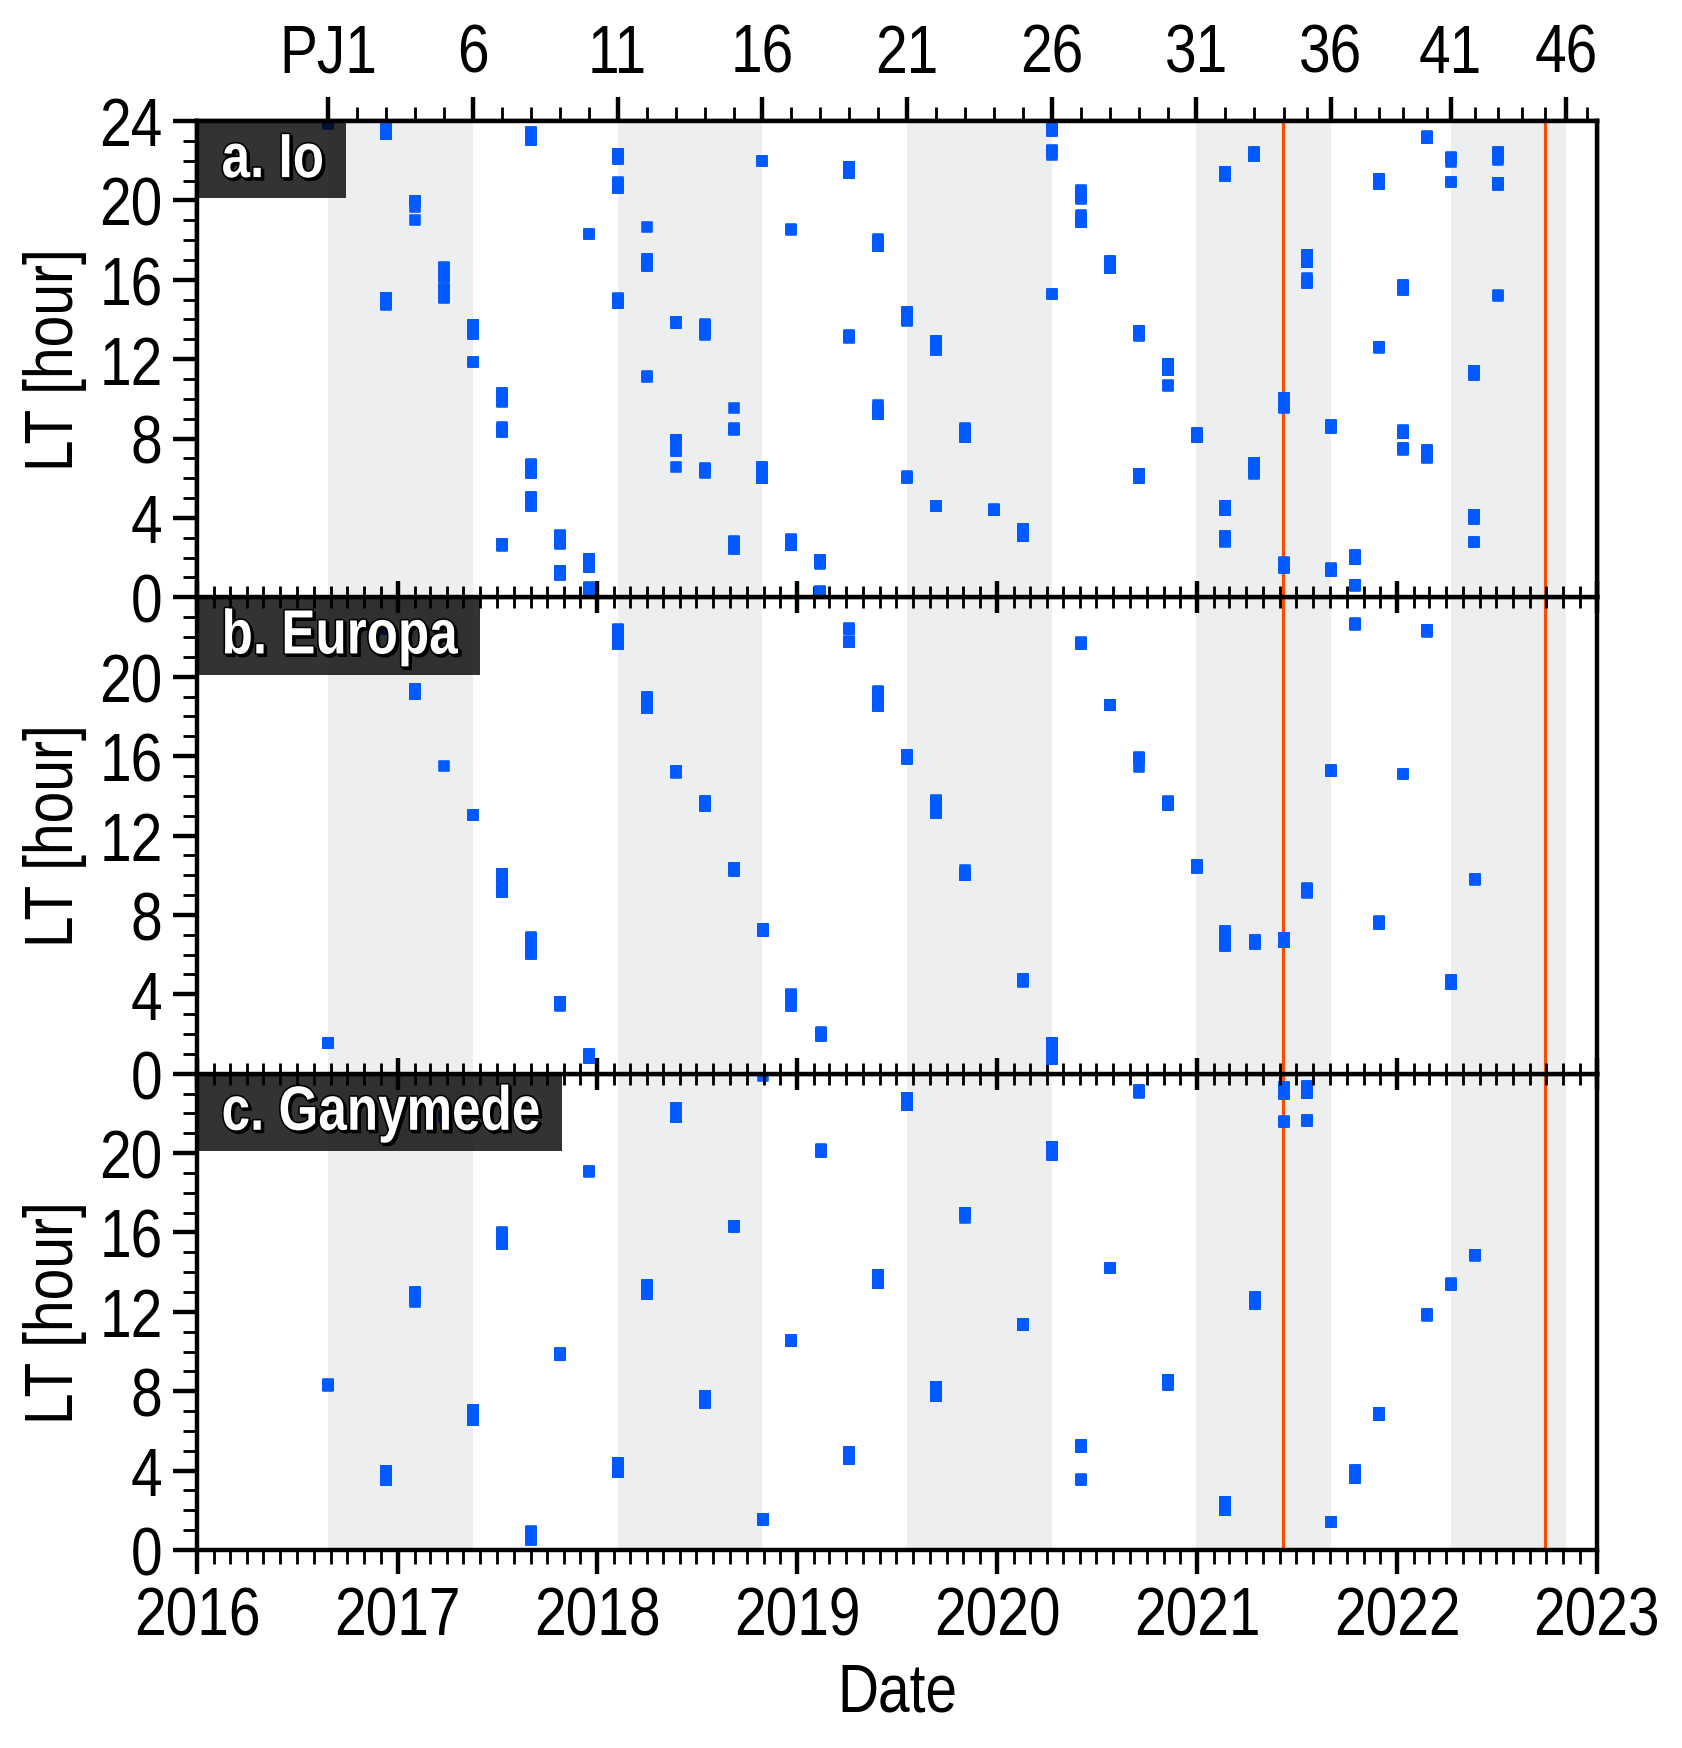

In [13]:
# %% 横軸をPJ番号でプロットする(4)
F = ShareXaxis()
F.fontsize = 22
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=3, figsize=(7.5, 7.5), dpi='L')
F.initialize()
F.panelname = [' a. Io ', ' b. Europa ', ' c. Ganymede ']

sxmin = '2016-01-01'
sxmax = '2023-01-01'
xmin = datetime.datetime.strptime(sxmin, '%Y-%m-%d')
xmax = datetime.datetime.strptime(sxmax, '%Y-%m-%d')
xticks = [datetime.datetime.strptime('2016-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2023-01-01', '%Y-%m-%d'),]
xticklabels = ['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
F.set_xaxis(label='Date',
            min=xmin, max=xmax,
            ticks=xticks,
            ticklabels=xticklabels,
            minor_num=12)
for i in range(F.ax.size):
    F.ax[i].minorticks_off()
    F.ax[i].xaxis.set_minor_locator(mdates.MonthLocator())
ticklabels = F.ax[2].get_xticklabels()
ticklabels[0].set_ha('center')

target_moon_list = ['Io', 'Europa', 'Ganymede']
for j in range(3):
    target_moon_0 = target_moon_list[j]

    PJ_LIST = [1, 3]+np.arange(4, 43+1, 1).tolist()
    if target_moon_0 == 'Io':
        Psyn = Psyn_io
    elif target_moon_0 == 'Europa':
        Psyn = Psyn_eu
        PJ_LIST.pop(24-2)
        PJ_LIST.pop(43-3)
    elif target_moon_0 == 'Ganymede':
        Psyn = Psyn_ga
        PJ_LIST.pop(24-2)
        PJ_LIST.pop(31-3)
        PJ_LIST.pop(39-4)
        PJ_LIST.pop(43-5)

    if j == 0:
        F.set_yaxis(ax_idx=j, label='LT [hour]',
                    min=0, max=24,
                    ticks=np.arange(0, 24+1, 4),
                    ticklabels=np.arange(0, 24+1, 4),
                    minor_num=4)
    else:
        F.set_yaxis(ax_idx=j, label='LT [hour]',
                    min=0, max=24,
                    ticks=np.arange(0, 24, 4),
                    ticklabels=np.arange(0, 24, 4),
                    minor_num=4)

    lt_med = np.zeros(len(PJ_LIST))
    k = 0
    for pj in PJ_LIST:
        wlon_fp, err_wlon_fp, lat_fp, err_lat_fp, moon_S3wlon, et_fp, hem_fp, pj_fp = Obsresults(
            [pj], target_moon_0, target_fp, TARGET_HEM='both', FLIP=False
        )

        eqlead_fp, eqlead_fp_0, eqlead_fp_1, wlon_TEB_eq = calc_eqlead(wlon_fp,
                                                                       err_wlon_fp,
                                                                       lat_fp,
                                                                       err_lat_fp,
                                                                       hem_fp,
                                                                       moon_S3wlon,
                                                                       target_moon)

        # 衛星ローカルタイムをリード角の分だけ補正
        moon_et = np.zeros(et_fp.size)
        for i in range(et_fp.size):
            t0 = spice.et2datetime(et_fp[i])
            omg_syn = 360/Psyn  # [deg/sec]
            tau_A = -eqlead_fp[i]/omg_syn  # Alfven travel time [sec]
            dt = datetime.timedelta(seconds=tau_A)
            moon_et[i] = spice.datetime2et(t0+dt)

        lt_arr = np.zeros(moon_et.size)
        d0 = spice.et2datetime(moon_et[0])
        d0_list = []
        for i in range(lt_arr.size):
            lt_arr[i] = local_time_moon2(moon_et[i], target_moon_0)
            d0_list += [d0]
        lt_med[k] = np.median(lt_arr)
        k += 1

        F.ax[j].scatter(d0_list, lt_arr,
                        s=9.0, marker='s', color=UC.blue,
                        linewidth=0.5, zorder=2.0)


# u_ax = F.upper_ax()
# u_ax.set_title(r'Flux tube mass contents',
#               fontsize=F.fontsize, weight='bold')

PJax = F.ax[0].twiny()
# PJax.set_title(r'Flux tube mass contents',
#                fontsize=F.fontsize, weight='bold')
xticks = [datetime.datetime.strptime('2016-08-27', '%Y-%m-%d'),
          datetime.datetime.strptime('2016-10-19', '%Y-%m-%d'),
          datetime.datetime.strptime('2016-12-11', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-02-02', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-03-27', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-05-19 06:00', '%Y-%m-%d %H:%M'),
          datetime.datetime.strptime('2017-07-11', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-09-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-10-24', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-12-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-02-07', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-04-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-05-24', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-07-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-09-07', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-10-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-12-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-02-12', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-04-06', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-05-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-07-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-09-12', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-11-03', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-12-26', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-02-17', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-04-10', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-06-02', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-07-25', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-09-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-11-08', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-12-30', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-02-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-04-15', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-06-08', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-07-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-09-02', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-10-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-11-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-01-12', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-02-25', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-04-09', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-05-23', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-07-05', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-08-17', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-09-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-11-06', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-12-15', '%Y-%m-%d'),]
xticklabels = ['PJ1', '', '', '', '',
               '6', '', '', '', '',
               '11', '', '', '', '',
               '16', '', '', '', '',
               '21', '', '', '', '',
               '26', '', '', '', '',
               '31', '', '', '', '',
               '36', '', '', '', '',
               '41', '', '', '', '',
               '46', '',]
PJax.set_xlim(xmin, xmax)
PJax.set_xticks(xticks[::5])
PJax.set_xticklabels(xticklabels[::5])
PJax.xaxis.set_minor_locator(FixedLocator(mdates.date2num(xticks)))
PJax.tick_params('y', grid_zorder=-10)

# Shades in each 5 perijove
for i in range(3):
    F.ax[i].axvspan(xticks[0], xticks[5], fc=UC.gray, ec=None, alpha=0.15)
    F.ax[i].axvspan(xticks[10], xticks[15], fc=UC.gray, ec=None, alpha=0.15)
    F.ax[i].axvspan(xticks[20], xticks[25], fc=UC.gray, ec=None, alpha=0.15)
    F.ax[i].axvspan(xticks[30], xticks[35], fc=UC.gray, ec=None, alpha=0.15)
    F.ax[i].axvspan(xticks[40], xticks[45], fc=UC.gray, ec=None, alpha=0.15)

# Satellite flyby
for i in range(3):
    F.ax[i].axvline(x=datetime.datetime.strptime('2021-06-07', '%Y-%m-%d'),
                    color=UC.red, linewidth=1.0, zorder=1.0)
    F.ax[i].axvline(x=datetime.datetime.strptime('2022-09-29', '%Y-%m-%d'),
                    color=UC.red, linewidth=1.0, zorder=1.0)
    F.ax[i].axvline(x=datetime.datetime.strptime('2023-12-30', '%Y-%m-%d'),
                    color=UC.red, linewidth=1.0, zorder=1.0)

time format 0
time format 1


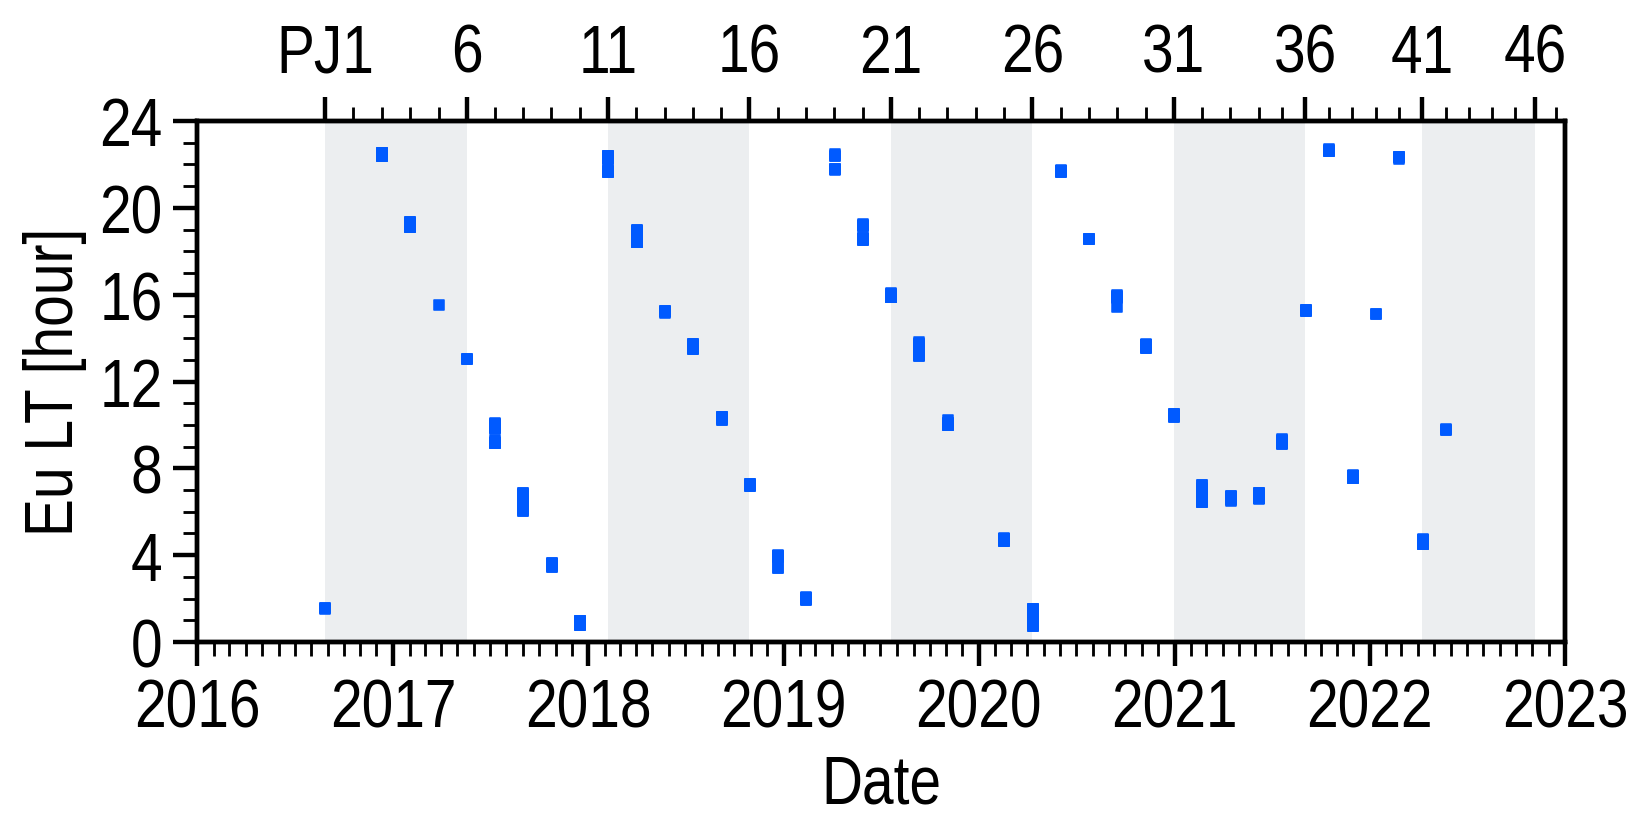

In [14]:
# %% 横軸をPJ番号でプロットする(5)
F = ShareXaxis()
F.fontsize = 22
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(7.5, 3.5), dpi='L')
F.initialize()

sxmin = '2016-01-01'
sxmax = '2023-01-01'
xmin = datetime.datetime.strptime(sxmin, '%Y-%m-%d')
xmax = datetime.datetime.strptime(sxmax, '%Y-%m-%d')
xticks = [datetime.datetime.strptime('2016-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2023-01-01', '%Y-%m-%d'),]
xticklabels = ['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
F.set_xaxis(label='Date',
            min=xmin, max=xmax,
            ticks=xticks,
            ticklabels=xticklabels,
            minor_num=12)
F.ax.minorticks_off()
F.ax.xaxis.set_minor_locator(mdates.MonthLocator())
ticklabels = F.ax.get_xticklabels()
ticklabels[0].set_ha('center')

PJ_LIST = [1, 3]+np.arange(4, 43+1, 1).tolist()
if target_moon == 'Io':
    Psyn = Psyn_io
elif target_moon == 'Europa':
    Psyn = Psyn_eu
    PJ_LIST.pop(24-2)
    PJ_LIST.pop(43-3)
elif target_moon == 'Ganymede':
    Psyn = Psyn_ga
    PJ_LIST.pop(24-2)
    PJ_LIST.pop(31-3)
    PJ_LIST.pop(39-4)
    PJ_LIST.pop(43-5)

F.set_yaxis(ax_idx=j, label=target_moon[0:2]+' LT [hour]',
            min=0, max=24,
            ticks=np.arange(0, 24+1, 4),
            ticklabels=np.arange(0, 24+1, 4),
            minor_num=4)

lt_med = np.zeros(len(PJ_LIST))
k = 0
for pj in PJ_LIST:
    wlon_fp, err_wlon_fp, lat_fp, err_lat_fp, moon_S3wlon, et_fp, hem_fp, pj_fp = Obsresults(
        [pj], target_moon, target_fp, TARGET_HEM='both', FLIP=False
    )

    eqlead_fp, eqlead_fp_0, eqlead_fp_1, wlon_TEB_eq = calc_eqlead(wlon_fp,
                                                                   err_wlon_fp,
                                                                   lat_fp,
                                                                   err_lat_fp,
                                                                   hem_fp,
                                                                   moon_S3wlon,
                                                                   target_moon)

    # 衛星ローカルタイムをリード角の分だけ補正
    moon_et = np.zeros(et_fp.size)
    for i in range(et_fp.size):
        t0 = spice.et2datetime(et_fp[i])
        omg_syn = 360/Psyn  # [deg/sec]
        tau_A = -eqlead_fp[i]/omg_syn  # Alfven travel time [sec]
        dt = datetime.timedelta(seconds=tau_A)
        moon_et[i] = spice.datetime2et(t0+dt)

    lt_arr = np.zeros(moon_et.size)
    d0 = spice.et2datetime(moon_et[0])
    d0_list = []
    for i in range(lt_arr.size):
        lt_arr[i] = local_time_moon2(moon_et[i], target_moon)
        d0_list += [d0]
    lt_med[k] = np.median(lt_arr)
    k += 1

    F.ax.scatter(d0_list, lt_arr,
                 s=9.0, marker='s', color=UC.blue,
                 linewidth=0.5, zorder=2.0)


# u_ax = F.upper_ax()
# u_ax.set_title(r'Flux tube mass contents',
#               fontsize=F.fontsize, weight='bold')

PJax = F.ax.twiny()
# PJax.set_title(r'Flux tube mass contents',
#                fontsize=F.fontsize, weight='bold')
xticks = [datetime.datetime.strptime('2016-08-27', '%Y-%m-%d'),
          datetime.datetime.strptime('2016-10-19', '%Y-%m-%d'),
          datetime.datetime.strptime('2016-12-11', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-02-02', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-03-27', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-05-19 06:00', '%Y-%m-%d %H:%M'),
          datetime.datetime.strptime('2017-07-11', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-09-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-10-24', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-12-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-02-07', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-04-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-05-24', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-07-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-09-07', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-10-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-12-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-02-12', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-04-06', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-05-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-07-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-09-12', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-11-03', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-12-26', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-02-17', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-04-10', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-06-02', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-07-25', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-09-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-11-08', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-12-30', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-02-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-04-15', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-06-08', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-07-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-09-02', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-10-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-11-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-01-12', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-02-25', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-04-09', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-05-23', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-07-05', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-08-17', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-09-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-11-06', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-12-15', '%Y-%m-%d'),]
xticklabels = ['PJ1', '', '', '', '',
               '6', '', '', '', '',
               '11', '', '', '', '',
               '16', '', '', '', '',
               '21', '', '', '', '',
               '26', '', '', '', '',
               '31', '', '', '', '',
               '36', '', '', '', '',
               '41', '', '', '', '',
               '46', '',]
PJax.set_xlim(xmin, xmax)
PJax.set_xticks(xticks[::5])
PJax.set_xticklabels(xticklabels[::5])
PJax.xaxis.set_minor_locator(FixedLocator(mdates.date2num(xticks)))
PJax.tick_params('y', grid_zorder=-10)

# Shades in each 5 perijove
F.ax.axvspan(xticks[0], xticks[5], fc=UC.gray, ec=None, alpha=0.15)
F.ax.axvspan(xticks[10], xticks[15], fc=UC.gray, ec=None, alpha=0.15)
F.ax.axvspan(xticks[20], xticks[25], fc=UC.gray, ec=None, alpha=0.15)
F.ax.axvspan(xticks[30], xticks[35], fc=UC.gray, ec=None, alpha=0.15)
F.ax.axvspan(xticks[40], xticks[45], fc=UC.gray, ec=None, alpha=0.15)

time format 0
ax idx: 0
time format 1
Min chi2: 9.12625140665715 at (array([22]), array([1]), array([34]))
Scale height [RJ]: 2.2302713697587864
Min chi2: 6.216166089400321 at (array([28]), array([0]), array([14]))
Scale height [RJ]: 1.4185324393405


/tmp/ipykernel_2157659/4238731014.py:283: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('turbo')


Min chi2: 15.208098138362477 at (array([13]), array([0]), array([58]))
Scale height [RJ]: 4.967336364562364
Min chi2: 7.270609835981681 at (array([28]), array([0]), array([34]))
Scale height [RJ]: 2.365560014163972
Min chi2: 2.8034611173485726 at (array([17]), array([0]), array([57]))
Scale height [RJ]: 4.810137983611292
Min chi2: 3.0584903960953933 at (array([22]), array([1]), array([27]))
Scale height [RJ]: 1.8340385818200942
Min chi2: 48.953054741553686 at (array([15]), array([0]), array([57]))
Scale height [RJ]: 4.810137983611292
Min chi2: 1.6482084657884286 at (array([30]), array([2]), array([14]))
Scale height [RJ]: 1.268773985061582
Min chi2: 26.17570786925807 at (array([24]), array([2]), array([0]))
Scale height [RJ]: 0.9914837366290987
Min chi2: 68.63810204133654 at (array([15]), array([0]), array([59]))
Scale height [RJ]: 5.129990253402048
Min chi2: 0.5181228245857631 at (array([35]), array([0]), array([2]))
Scale height [RJ]: 1.1407911790168306
Min chi2: 0.4323418134856346 a

Min chi2: 2.6199848270382984 at (array([29]), array([0]), array([14]))
Scale height [RJ]: 1.4185324393405
Min chi2: 200.44216757736558 at (array([14]), array([0]), array([44]))
Scale height [RJ]: 3.191500619999847
Min chi2: 6.840571869002739 at (array([25]), array([1]), array([40]))
Scale height [RJ]: 2.663292255758181
Min chi2: 3.712264712755976 at (array([23]), array([0]), array([56]))
Scale height [RJ]: 4.658221850327204
Min chi2: 34.81141613848742 at (array([22]), array([2]), array([48]))
Scale height [RJ]: 3.2325303448297333
Min chi2: 6.372013577489199 at (array([0]), array([0]), array([26]))
Scale height [RJ]: 1.8940361862156747
Min chi2: 79.13656688352107 at (array([32]), array([1]), array([9]))
Scale height [RJ]: 1.209847397113539
Min chi2: 3.612130426995619 at (array([26]), array([2]), array([6]))
Scale height [RJ]: 1.0877355325558271
Min chi2: 188.25360735016486 at (array([23]), array([0]), array([42]))
Scale height [RJ]: 3.001615616699574
Min chi2: 84.79745414714108 at (arra

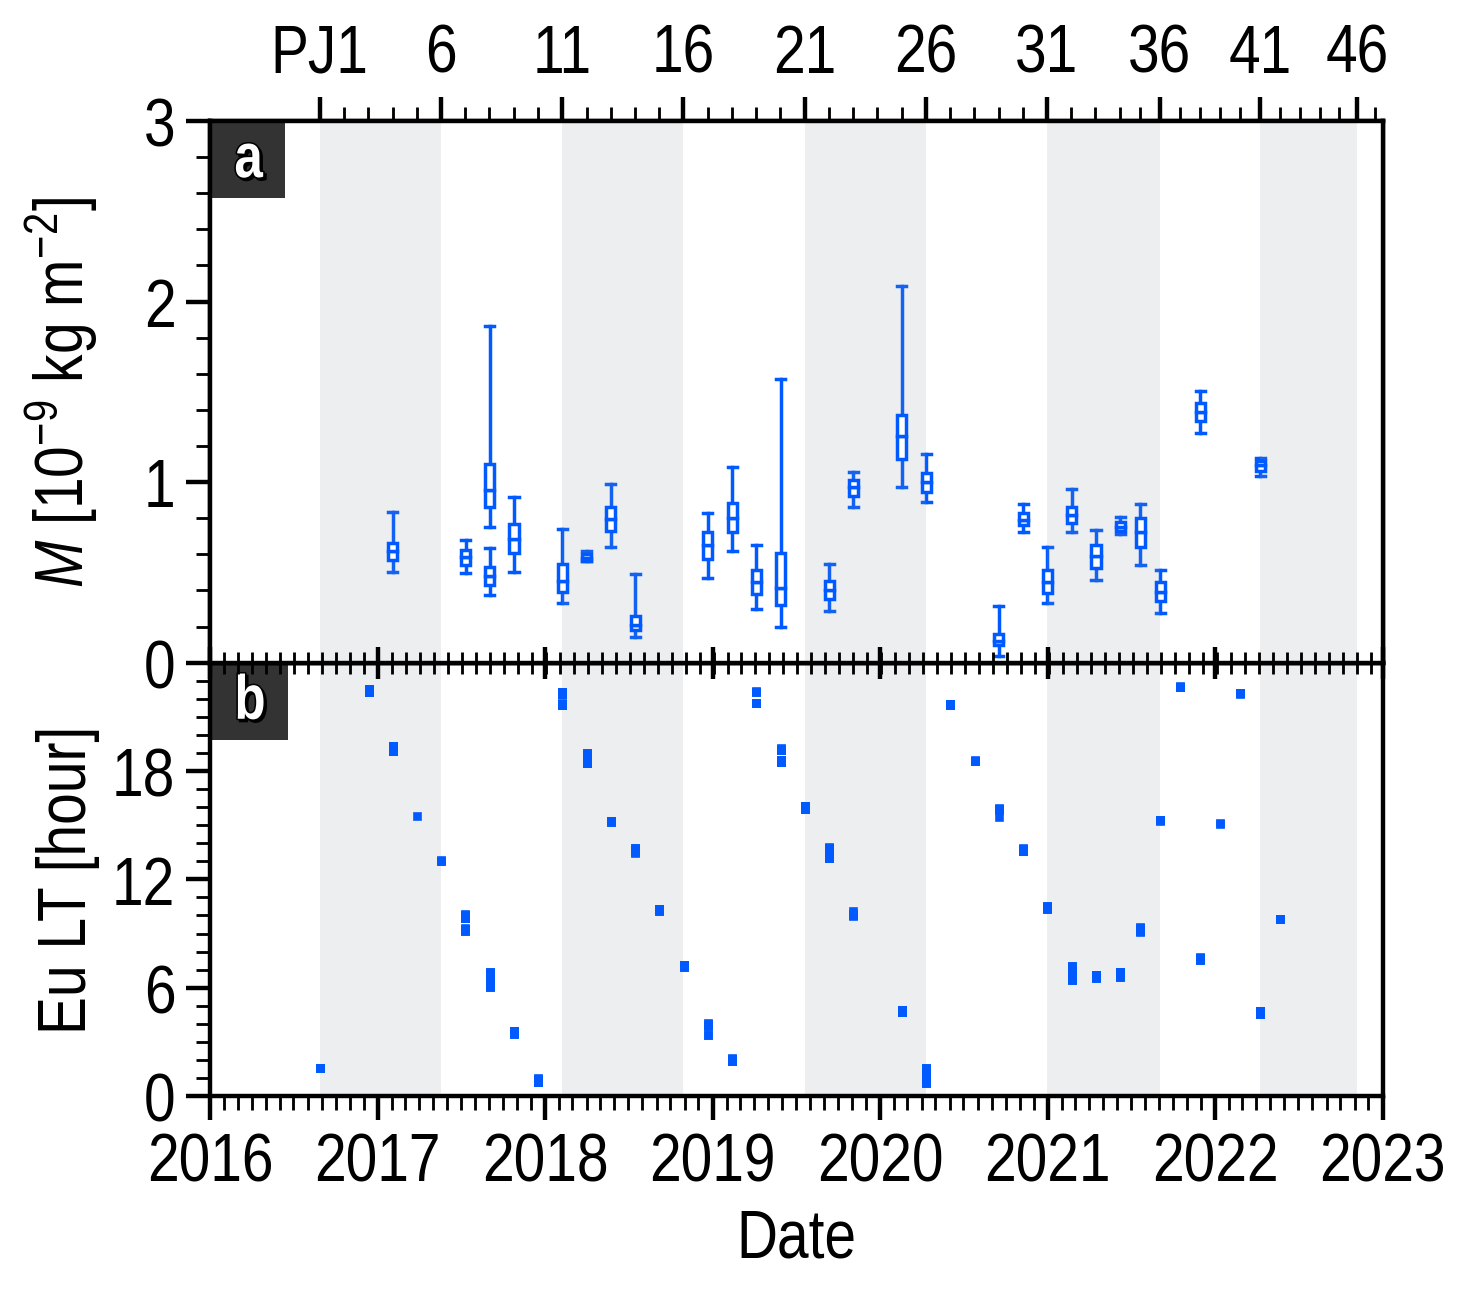

In [15]:
# %% 横軸をPJ番号でプロットする(6)
F = ShareXaxis()
F.fontsize = 22
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=2, figsize=(6.5, 5.5), height_ratios=[1, 0.8], dpi='L')
F.initialize()
# F.panelname = [' a. Io ', ' b. Europa ', ' c. Ganymede ']

sxmin = '2016-01-01'
sxmax = '2023-01-01'
xmin = datetime.datetime.strptime(sxmin, '%Y-%m-%d')
xmax = datetime.datetime.strptime(sxmax, '%Y-%m-%d')
xticks = [datetime.datetime.strptime('2016-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-01-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2023-01-01', '%Y-%m-%d'),]
xticklabels = ['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
F.set_xaxis(label='Date',
            min=xmin, max=xmax,
            ticks=xticks,
            ticklabels=xticklabels,
            minor_num=12)
F.ax[1].minorticks_off()
F.ax[1].xaxis.set_minor_locator(mdates.MonthLocator())
ticklabels = F.ax[1].get_xticklabels()
ticklabels[0].set_ha('center')

PJ_LIST = [1, 3]+np.arange(4, 43+1, 1).tolist()
if target_moon == 'Io':
    Psyn = Psyn_io
elif target_moon == 'Europa':
    Psyn = Psyn_eu
    PJ_LIST.pop(24-2)
    PJ_LIST.pop(43-3)
elif target_moon == 'Ganymede':
    Psyn = Psyn_ga
    PJ_LIST.pop(24-2)
    PJ_LIST.pop(31-3)
    PJ_LIST.pop(39-4)
    PJ_LIST.pop(43-5)

if (exdate == '003/20250516') and (target_moon == 'Europa'):
    exnum = ['001', '002', '005', '006',
             '007', '010', '011',
             '012', '013', '014', '015', '016',
             '017', '018', '019', '020', '021',
             '022', '023', '024', '025', '026',
             '027', '028', '029', '030', '031',
             '032', '034', '035', '036',
             '037', '038',
             '039', '040', '041', '042'
             ]
    PJ_list = [3, 4, 8, 9,
               10, 13, 14,
               15, 16, 17, 18, 19,
               20, 21, 22, 23, 25,
               26, 27, 28, 29, 30,
               31, 32, 33, 34, 35,
               36, 38, 40, 41,
               7, 7,
               11, 11, 12, 12,
               ]
    Psyn = Psyn_eu
    ymax = 4.1
    ticks = np.arange(0, 4+1, 1)

elif (exdate == '003/20250516') and (target_moon == 'Io'):
    exnum = ['047', '048', '049', '050', '051',
             '052', '053', '054', '055', '056', '057',
             '058', '059',
             '062', '063', '064', '065', '066',
             '067', '068', '069', '070', '071',
             '072', '073', '074', '075', '076',
             '077', '078', '079', '080', '081',
             '083',
             '084', '085', '086', '088',
             '089', '090', '091', '092', '094',
             '095', '096', '097', '098',
             '114', '116',
             ]
    PJ_list = [3, 4, 5, 6, 7,
               8, 8, 9, 9, 10, 10,
               11, 11,
               13, 14, 15, 16, 17,
               18, 19, 20, 21, 22,
               23, 24, 25, 26, 27,
               27, 28, 29, 30, 31,
               32,
               33, 33, 34, 35,
               36, 37, 38, 39, 40,
               41, 42, 43, 43,
               18, 12,
               ]
    Psyn = Psyn_io
    ymax = 40
    ticks = np.arange(0, 40+1, 10)

elif (exdate == '003/20250516') and (target_moon == 'Ganymede'):
    exnum = ['100', '104', '105', '106', '107',
             '108', '109', '110', '111', '112',
             '113', '118', '119', '120', '121',
             '123', '124', '125', '126', '127',
             '128', '129', '131', '132', '134',
             '133', '136', '137', '138', '139',
             '140', '141', '142', '143',
             ]
    PJ_list = [3, 4, 5, 6, 7,
               8, 11, 12, 13, 14,
               15, 16, 17, 18, 19,
               20, 21, 22, 23, 25,
               26, 27, 29, 30, 32,
               33, 34, 34, 35, 37,
               38, 40, 41, 42,
               ]
    Psyn = Psyn_ga
    ymax = 0.24
    ticks = np.arange(0, 0.30, 0.10)

elif (exdate == '005/20250923') and (target_moon == 'Europa'):
    exnum = ['024', '025', '003', '004', '008',
             '009', '007', '010', '011', '012',
             '051', '053', '014', '015',
             # '016', '017',
             '018', '020', '021', '022',
             '023', '026', '029', '030', '052',
             # '032',
             '033', '034', '035', '036', '037', '040',
             '041', '042', '043', '044', '045', '046',
             # '047',
             '048', '050',
             ]
    PJ_list = [3, 4, 5, 7, 8,
               8, 9, 10, 11, 11,
               12, 12, 13, 14,
               # 15, 16,
               17, 18, 19, 20,
               21, 22, 23, 25, 26,
               # 27,
               28, 29, 30, 31, 32, 33,
               34, 35, 36, 38, 40, 41,
               # 45,
               48, 62,
               ]
    FTMC_HEM = ['S', 'S', 'N', 'S', 'N',
                'S', 'S', 'N', 'N', 'S',
                'N', 'S', 'N', 'S',
                # 'S', 'S',
                'both', 'S', 'both', 'both',
                'S', 'both', 'S', 'S', 'S',
                # 'N',
                'N', 'both', 'S', 'S', 'both', 'S',
                'S', 'S', 'N', 'S', 'S', 'S',
                # 'S',
                'S', 'S',
                ]
    Psyn = Psyn_eu
    ymax = 3.0
    ticks = np.arange(0, 3+1, 1)

elif (exdate == '005/20251221') and (target_moon == 'Europa'):
    exnum = ['333', '334', '335', '336', '362',
             '338', '339', '340', '341', '342',
             '363', '344', '345', '346', '347',
             '348', '349', '350', '351', '352',
             '353', '354', '355', '356', '357',
             '358', '359', '360', '361',
             ]
    PJ_list = [4, 7, 8, 8, 9,
               11, 12, 13, 14, 17,
               18, 19, 20, 22, 23,
               25, 26, 29, 30, 31,
               32, 33, 34, 35, 36,
               38, 41, 48, 62,
               ]
    FTMC_HEM = ['S', 'S', 'N', 'S', 'S',
                'S', 'N', 'N', 'S', 'both',
                'S', 'both', 'both', 'both', 'S',
                'S', 'S', 'both', 'S', 'S',
                'both', 'S', 'S', 'S', 'N',
                'S', 'S', 'S', 'S',
                ]
    Psyn = Psyn_eu
    ymax = 3.0
    ticks = np.arange(0, 3+1, 1)

elif (exdate == '005/20250923') and (target_moon == 'Ganymede'):
    exnum = ['054', '055', '056', '057', '058',
             '059', '063', '065', '068',  # '070',
             '071', '072', '073', '075', '076',
             '078', '079', '081', '082', '083',
             '084', '085', '086', '087', '088',
             '089', '090', '091', '092', '093',
             '094', '095', '096', '097', '098',
             '099', '100', '101', '102', '103',
             '104', '105', '106',
             # '107',
             # '108', '109',
             ]
    PJ_list = [3, 4, 5, 6, 7,
               8, 11, 12, 13,  # 14,
               15, 16, 17, 19, 20,
               21, 21, 22, 23, 25,
               26, 27, 29, 30, 32,
               32, 33, 34, 34, 35,
               37, 38, 40, 41, 42,
               46, 47, 48, 49, 50,
               58, 59, 60,
               # 22,
               # 3, 3,
               ]
    FTMC_HEM = ['both', 'both', 'S', 'both', 'S',
                'both', 'N', 'both', 'both',  # 'S',
                'N', 'S', 'S', 'S', 'N',
                'N', 'S', 'N', 'both', 'S',
                'S', 'both', 'S', 'S', 'N',
                'S', 'both', 'N', 'S', 'both',
                'S', 'S', 'S', 'N', 'N',
                'S', 'S', 'S', 'S', 'S',
                'S', 'S', 'N',
                # 'S',
                # 'N', 'S',
                ]
    Psyn = Psyn_ga
    ymax = 0.2
    ticks = np.round(np.arange(0, 0.20+0.01, 0.05), 2)

elif (exdate == '005/20251221') and (target_moon == 'Ganymede'):
    exnum = ['301', '302', '303', '304', '305',
             '306', '307', '308', '309', '310',
             '311', '312', '313', '314', '315',
             '316', '317', '318', '319', '320',
             '321', '322', '323', '324', '325',
             '326', '327', '328', '329', '330',
             '331', '332',
             ]
    PJ_list = [3, 4, 5, 6,
               7,
               8, 11, 12, 13, 16,
               17, 19, 20, 21, 22,
               25, 27, 30, 32, 34,
               34, 35, 37, 38, 40,
               41, 42, 46, 47, 50,
               59, 60,
               ]
    FTMC_HEM = ['both', 'both', 'S', 'both', 'S',
                'both', 'N', 'both', 'both', 'S',
                'S', 'S', 'N', 'S', 'N',
                'S', 'both', 'S', 'S', 'N',
                'S', 'both', 'S', 'S', 'S',
                'N', 'N', 'S', 'S', 'S',
                'S', 'N',
                ]
    Psyn = Psyn_ga
    ymax = 0.2
    ticks = np.round(np.arange(0, 0.20+0.01, 0.05), 2)

column_mass_1dN = np.loadtxt(
    'results/column_mass/'+exdate+'_'+target_moon+'/col_massdens_1dN.txt')
column_mass_1dS = np.loadtxt(
    'results/column_mass/'+exdate+'_'+target_moon+'/col_massdens_1dS.txt')
ftmc_mag_1dN = np.loadtxt(
    'results/column_mass/'+exdate+'_'+target_moon+'/ftmc_mag_1dN.txt')
ftmc_mag_1dS = np.loadtxt(
    'results/column_mass/'+exdate+'_'+target_moon+'/ftmc_mag_1dS.txt')
column_mass_1d = column_mass_1dN+column_mass_1dS
column_mass_3d = column_mass_1d.reshape(ni_num, Ai_num, Ti_num)
ftmc_mag_1d = ftmc_mag_1dN + ftmc_mag_1dS
ftmc_mag_3d = ftmc_mag_1d.reshape(ni_num, Ai_num, Ti_num)

F.set_yaxis(ax_idx=0,
            label='$M$ [10$^{-9}$ kg m$^{-2}$]',
            min=0, max=ymax,
            ticks=ticks,
            ticklabels=ticks,
            minor_num=5)

positions = np.arange(0, len(exnum)+1, 1)
colormap = plt.cm.get_cmap('turbo')
for i in range(len(exnum)):
    # %% Load the data
    exname = exdate+'_'+exnum[i]
    column_mass, chi2r, moon_et, _, moon_S3wlon, weight = data_load(
        exname)     # [kg m-2]
    column_mass *= 1E+9  # [10^-9 kg m-2]

    # Local time
    d0 = spice.et2datetime(moon_et[0])
    d0_list = []
    for ii in range(column_mass.size):
        d0_list += [d0]
    lt_arr = np.zeros(moon_et.size)
    for k in range(moon_et.size):
        lt_arr[k] = local_time_moon(moon_et[k], target_moon)

    lt_center = (lt_arr[0]+lt_arr[-1])/2

    q1, medians, q3 = weighted_percentile(data=column_mass,
                                          perc=[0.25, 0.5, 0.75],
                                          weights=weight)
    width = datetime.timedelta(seconds=60*60*24*20)
    weighted_boxplot2(F.ax[0], d0, q1, medians, q3,
                      np.min(column_mass),
                      np.max(column_mass), width=width,
                      ec=UC.blue, lw=1.1)


#
#
#
#
F.set_yaxis(ax_idx=1, label=target_moon[0:2]+' LT [hour]',
            min=0, max=24,
            ticks=np.arange(0, 24, 6),
            ticklabels=np.arange(0, 24, 6),
            minor_num=6)

lt_med = np.zeros(len(PJ_LIST))
k = 0
for pj in PJ_LIST:
    wlon_fp, err_wlon_fp, lat_fp, err_lat_fp, moon_S3wlon, et_fp, hem_fp, pj_fp = Obsresults(
        [pj], target_moon, target_fp, TARGET_HEM='both', FLIP=False
    )

    eqlead_fp, eqlead_fp_0, eqlead_fp_1, wlon_TEB_eq = calc_eqlead(wlon_fp,
                                                                   err_wlon_fp,
                                                                   lat_fp,
                                                                   err_lat_fp,
                                                                   hem_fp,
                                                                   moon_S3wlon,
                                                                   target_moon)

    # 衛星ローカルタイムをリード角の分だけ補正
    moon_et = np.zeros(et_fp.size)
    for i in range(et_fp.size):
        t0 = spice.et2datetime(et_fp[i])
        omg_syn = 360/Psyn  # [deg/sec]
        tau_A = -eqlead_fp[i]/omg_syn  # Alfven travel time [sec]
        dt = datetime.timedelta(seconds=tau_A)
        moon_et[i] = spice.datetime2et(t0+dt)

    lt_arr = np.zeros(moon_et.size)
    d0 = spice.et2datetime(moon_et[0])
    d0_list = []
    for i in range(lt_arr.size):
        lt_arr[i] = local_time_moon2(moon_et[i], target_moon)
        d0_list += [d0]
    lt_med[k] = np.median(lt_arr)
    k += 1

    F.ax[1].scatter(d0_list, lt_arr,
                    s=5.0, marker='s', color=UC.blue,
                    linewidth=0.2, zorder=2.0)


# u_ax = F.upper_ax()
# u_ax.set_title(r'Flux tube mass contents',
#               fontsize=F.fontsize, weight='bold')

PJax = F.ax[0].twiny()
# PJax.set_title(r'Flux tube mass contents',
#                fontsize=F.fontsize, weight='bold')
xticks = [datetime.datetime.strptime('2016-08-27', '%Y-%m-%d'),
          datetime.datetime.strptime('2016-10-19', '%Y-%m-%d'),
          datetime.datetime.strptime('2016-12-11', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-02-02', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-03-27', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-05-19 06:00', '%Y-%m-%d %H:%M'),
          datetime.datetime.strptime('2017-07-11', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-09-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-10-24', '%Y-%m-%d'),
          datetime.datetime.strptime('2017-12-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-02-07', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-04-01', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-05-24', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-07-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-09-07', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-10-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2018-12-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-02-12', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-04-06', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-05-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-07-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-09-12', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-11-03', '%Y-%m-%d'),
          datetime.datetime.strptime('2019-12-26', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-02-17', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-04-10', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-06-02', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-07-25', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-09-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-11-08', '%Y-%m-%d'),
          datetime.datetime.strptime('2020-12-30', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-02-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-04-15', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-06-08', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-07-21', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-09-02', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-10-16', '%Y-%m-%d'),
          datetime.datetime.strptime('2021-11-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-01-12', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-02-25', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-04-09', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-05-23', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-07-05', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-08-17', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-09-29', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-11-06', '%Y-%m-%d'),
          datetime.datetime.strptime('2022-12-15', '%Y-%m-%d'),]
xticklabels = ['PJ1', '', '', '', '',
               '6', '', '', '', '',
               '11', '', '', '', '',
               '16', '', '', '', '',
               '21', '', '', '', '',
               '26', '', '', '', '',
               '31', '', '', '', '',
               '36', '', '', '', '',
               '41', '', '', '', '',
               '46', '',]
PJax.set_xlim(xmin, xmax)
PJax.set_xticks(xticks[::5])
PJax.set_xticklabels(xticklabels[::5])
PJax.xaxis.set_minor_locator(FixedLocator(mdates.date2num(xticks)))
PJax.tick_params('y', grid_zorder=-10)

# Shades in each 5 perijove
for i in range(2):
    F.ax[i].axvspan(xticks[0], xticks[5], fc=UC.gray, ec=None, alpha=0.15)
    F.ax[i].axvspan(xticks[10], xticks[15], fc=UC.gray, ec=None, alpha=0.15)
    F.ax[i].axvspan(xticks[20], xticks[25], fc=UC.gray, ec=None, alpha=0.15)
    F.ax[i].axvspan(xticks[30], xticks[35], fc=UC.gray, ec=None, alpha=0.15)
    F.ax[i].axvspan(xticks[40], xticks[45], fc=UC.gray, ec=None, alpha=0.15)

F.fig.savefig('img/ftmc_lt_'+target_moon[0:2]+'_r.pdf', bbox_inches='tight')
plt.show()

In [16]:
# %% フィッティング用の三角関数
def fit_func2(params, x):
    a, c, d = params
    return a * np.cos(2*np.pi*(x-c)/24.0) + d

In [17]:
x_arr = np.zeros(3)
y_arr = np.zeros(3)
x_err_arr = np.zeros(3)
medians_arr = np.zeros(len(exnum))
q05_arr = np.zeros(len(exnum))
q25_arr = np.zeros(len(exnum))
q75_arr = np.zeros(len(exnum))
q95_arr = np.zeros(len(exnum))
medians_x = np.zeros(len(exnum))
medians_x_err = np.zeros(len(exnum))
y_sigma_arr = np.zeros(len(exnum))
jj = 0
for ii in range(2):
    for i in range(len(exnum)):
        # %% Load the data
        exname = exdate+'_'+exnum[i]
        column_mass, chi2r, moon_et, _, moon_S3wlon, weight = data_load(
            exname)     # [kg m-2]
        column_mass *= 1E+9  # [10^-9 kg m-2]

        # Local time
        lt_arr = np.zeros(moon_et.size)
        for k in range(moon_et.size):
            lt_arr[k] = local_time_moon(moon_et[k], target_moon)

        lt_center = ((lt_arr[0]+lt_arr[-1])/2)+24.0*ii
        lt_range = abs(lt_arr[0]-lt_arr[-1])

        q25, medians, q75 = weighted_percentile(data=column_mass,
                                                perc=[0.25, 0.5, 0.75],
                                                weights=weight)
        q05, medians, q95 = weighted_percentile(data=column_mass,
                                                perc=[0.05, 0.5, 0.95],
                                                weights=weight)

        if jj < len(exnum):
            x_arr = np.append(x_arr, lt_center*np.ones(column_mass.size))
            y_arr = np.append(y_arr, column_mass)
            x_err_arr = np.append(x_err_arr, lt_range *
                                  np.ones(column_mass.size))

            medians_arr[jj] = medians
            q05_arr[jj] = q05
            q25_arr[jj] = q25
            q75_arr[jj] = q75
            q95_arr[jj] = q95
            medians_x[jj] = lt_center
            medians_x_err[jj] = lt_range
            y_sigma_arr[jj] = np.std(column_mass)
            jj += 1

Min chi2: 9.12625140665715 at (array([22]), array([1]), array([34]))
Scale height [RJ]: 2.2302713697587864
Min chi2: 6.216166089400321 at (array([28]), array([0]), array([14]))
Scale height [RJ]: 1.4185324393405
Min chi2: 15.208098138362477 at (array([13]), array([0]), array([58]))
Scale height [RJ]: 4.967336364562364
Min chi2: 7.270609835981681 at (array([28]), array([0]), array([34]))
Scale height [RJ]: 2.365560014163972
Min chi2: 2.8034611173485726 at (array([17]), array([0]), array([57]))
Scale height [RJ]: 4.810137983611292
Min chi2: 3.0584903960953933 at (array([22]), array([1]), array([27]))
Scale height [RJ]: 1.8340385818200942
Min chi2: 48.953054741553686 at (array([15]), array([0]), array([57]))
Scale height [RJ]: 4.810137983611292
Min chi2: 1.6482084657884286 at (array([30]), array([2]), array([14]))
Scale height [RJ]: 1.268773985061582
Min chi2: 26.17570786925807 at (array([24]), array([2]), array([0]))
Scale height [RJ]: 0.9914837366290987
Min chi2: 68.63810204133654 at (a

Min chi2: 19.78425176183982 at (array([34]), array([0]), array([28]))
Scale height [RJ]: 1.9986086848032687
Min chi2: 31.50768607025124 at (array([27]), array([2]), array([37]))
Scale height [RJ]: 2.3099196156428383
Min chi2: 1.0323816486123791 at (array([27]), array([0]), array([38]))
Scale height [RJ]: 2.6604036816623915
Min chi2: 1.0370903656358434 at (array([26]), array([0]), array([32]))
Scale height [RJ]: 2.2338131668178125
Min chi2: 9.12625140665715 at (array([22]), array([1]), array([34]))
Scale height [RJ]: 2.2302713697587864
Min chi2: 6.216166089400321 at (array([28]), array([0]), array([14]))
Scale height [RJ]: 1.4185324393405
Min chi2: 15.208098138362477 at (array([13]), array([0]), array([58]))
Scale height [RJ]: 4.967336364562364
Min chi2: 7.270609835981681 at (array([28]), array([0]), array([34]))
Scale height [RJ]: 2.365560014163972
Min chi2: 2.8034611173485726 at (array([17]), array([0]), array([57]))
Scale height [RJ]: 4.810137983611292
Min chi2: 3.0584903960953933 at

Best fit: [0.19639463 3.85796997 0.69773944]
Error: [0.05627885 1.35960679 0.04125703]
lmean: 0.5013824712107325 0.8941295005002606
cov_beta: [[ 3.16730928e-03 -3.07411136e-02  3.69318885e-04]
 [-3.07411136e-02  1.84853061e+00 -1.49785518e-02]
 [ 3.69318885e-04 -1.49785518e-02  1.70214274e-03]]
res_var: 14.47602216285991
Check: [0.05627885 1.35960679 0.04125703]
Jacobian: (3, 120) (3, 3) (120,)
Min chi2: 9.12625140665715 at (array([22]), array([1]), array([34]))
Scale height [RJ]: 2.2302713697587864
Min chi2: 6.216166089400321 at (array([28]), array([0]), array([14]))
Scale height [RJ]: 1.4185324393405
Min chi2: 15.208098138362477 at (array([13]), array([0]), array([58]))
Scale height [RJ]: 4.967336364562364
Min chi2: 7.270609835981681 at (array([28]), array([0]), array([34]))
Scale height [RJ]: 2.365560014163972


Min chi2: 2.8034611173485726 at (array([17]), array([0]), array([57]))
Scale height [RJ]: 4.810137983611292
Min chi2: 3.0584903960953933 at (array([22]), array([1]), array([27]))
Scale height [RJ]: 1.8340385818200942
Min chi2: 48.953054741553686 at (array([15]), array([0]), array([57]))
Scale height [RJ]: 4.810137983611292
Min chi2: 1.6482084657884286 at (array([30]), array([2]), array([14]))
Scale height [RJ]: 1.268773985061582
Min chi2: 26.17570786925807 at (array([24]), array([2]), array([0]))
Scale height [RJ]: 0.9914837366290987
Min chi2: 68.63810204133654 at (array([15]), array([0]), array([59]))
Scale height [RJ]: 5.129990253402048
Min chi2: 0.5181228245857631 at (array([35]), array([0]), array([2]))
Scale height [RJ]: 1.1407911790168306
Min chi2: 0.4323418134856346 at (array([20]), array([0]), array([31]))
Scale height [RJ]: 2.1715844282369714
Min chi2: 2.6199848270382984 at (array([29]), array([0]), array([14]))
Scale height [RJ]: 1.4185324393405
Min chi2: 200.44216757736558 a

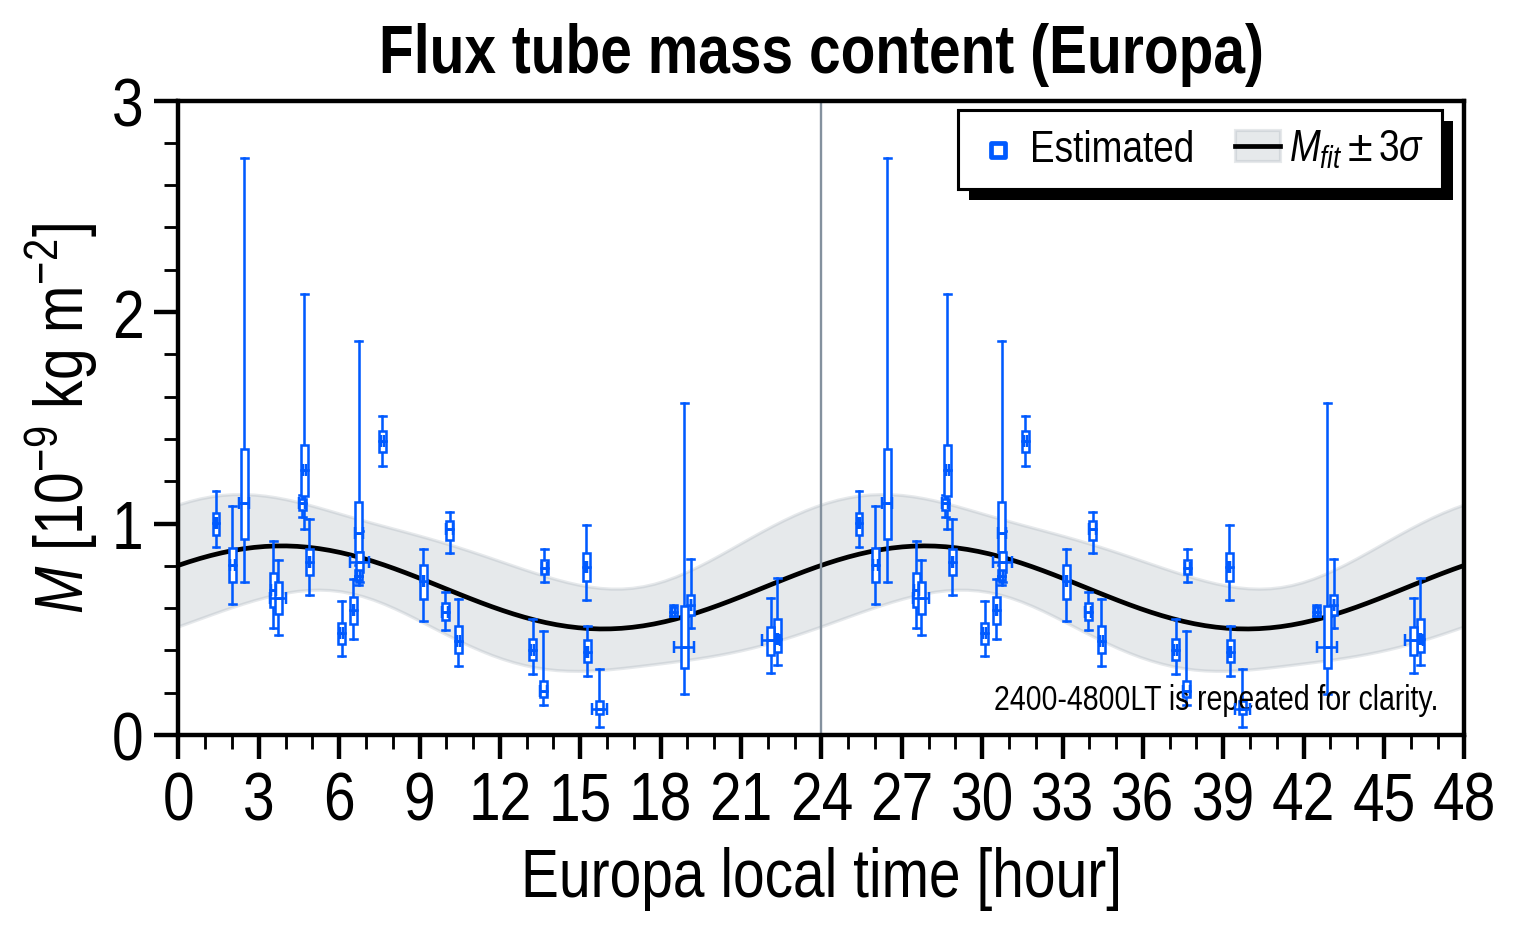

In [18]:
from matplotlib.ticker import FormatStrFormatter
from scipy.odr import ODR, Model, RealData
from Leadangle_fit_JunoUVS import spice_moonS3
from scipy.stats import spearmanr
from scipy.stats import t

# %% 横軸LT(48時間) 散布図 ベストフィット付き (これが一番大事)
F = ShareXaxis()
F.fontsize = 22
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(7, 4), dpi='L')
F.initialize()

F.set_xaxis(label=target_moon+' local time [hour]',
            min=0, max=48,
            ticks=np.arange(0, 48+1, 3),
            ticklabels=np.arange(0, 48+1, 3),
            minor_num=3)
F.set_yaxis(ax_idx=0,
            label=r'$M$ [10$^{-9}$ kg m$^{-2}$]',
            min=0, max=ymax,
            ticks=ticks,
            ticklabels=ticks,
            minor_num=5)
# F.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

x_arr = medians_x
y_arr = medians_arr
x_err_arr = medians_x_err/2
y_err_arr = y_sigma_arr

sort = np.argsort(x_arr)[::-1]
x_arr, y_arr, x_err_arr, y_err_arr = x_arr[sort], y_arr[sort], x_err_arr[sort], y_err_arr[sort]

# ODR 用データとモデルの設定
data = RealData(x_arr, y_arr, sx=x_err_arr, sy=y_err_arr)
model = Model(fit_func2)

# ODR 実行
odr_instance = ODR(data, model, beta0=[1.0, 1.0, 1.0])
output = odr_instance.run()

# フィッティング結果
popt = output.beta
perr = output.sd_beta  # *np.sqrt(output.res_var)
cov = output.cov_beta*output.res_var

# ベストフィット
nstd = 3  # 95% 信頼区間
x_fit = np.linspace(0.0, 48.0, 120)
y_fit = fit_func2(popt, x_fit)
lmean, = F.ax.plot(x_fit, y_fit, zorder=0.1, label='1', color='k')
print('Best fit:', popt)
print('Error:', perr)
print('lmean:', np.min(y_fit), np.max(y_fit))
print('cov_beta:', cov)
print('res_var:', output.res_var)
print('Check:', np.sqrt(np.diag(output.cov_beta*output.res_var)))

# 予測区間の計算
if target_moon == 'Io':
    y_fit_err2 = ((np.pi*popt[0]/12.0)*np.sin(np.pi*(x_fit-popt[1])/12.0)**2)*(
        perr[1]**2) + (np.cos(np.pi*(x_fit-popt[1])/12.0)*perr[0])**2 + perr[2]**2
    y_fit_err = np.sqrt(y_fit_err2)
    y_fit_up = y_fit + nstd * y_fit_err
    y_fit_dw = y_fit - nstd * y_fit_err

if target_moon == 'Europa' or target_moon == 'Ganymede':
    # ヤコビアンの計算
    J_f0 = np.cos(np.pi*(x_fit-popt[1])/12.0)
    J_f1 = (np.pi*popt[0]/12.0)*np.sin(np.pi*(x_fit-popt[1])/12.0)
    J_f2 = 1.0*np.ones(J_f0.shape)
    J_f = np.array([J_f0, J_f1, J_f2])
    sigma_f = np.zeros(x_fit.size)
    for i in range(x_fit.size):
        sigma_f[i] = np.sqrt((J_f[:, i]@cov)@J_f[:, i].T)
    y_fit_up = y_fit + 3.0*sigma_f
    y_fit_dw = y_fit - 3.0*sigma_f
    print('Jacobian:', J_f.shape, cov.shape, sigma_f.shape)

lsigma = F.ax.fill_between(x_fit, y_fit_up, y_fit_dw,
                           color=UC.gray, alpha=0.2,
                           label='2',
                           zorder=0.01)


jj = 0
median_arr = np.zeros(len(exnum))
median_error = np.zeros(len(exnum))
lt_center_arr = np.zeros(len(exnum))
for ii in range(2):
    for i in range(len(exnum)):
        # %% Load the data
        exname = exdate+'_'+exnum[i]
        column_mass, chi2r, moon_et, _, _, weight = data_load(
            exname)     # [kg m-2]
        column_mass *= 1E+9  # [10^-9 kg m-2]

        # Local time
        lt_arr = np.zeros(moon_et.size)
        s3_arr = np.zeros(moon_et.size)
        for k in range(moon_et.size):
            lt_arr[k] = local_time_moon(moon_et[k], target_moon)
            _, _, _, _, _, _, s3_arr[k] = spice_moonS3(moon_et[k], target_moon)

        lt_center = ((lt_arr[0]+lt_arr[-1])/2)+24.0*ii
        lt_range = abs(lt_arr[0]-lt_arr[-1])

        q1, medians, q3 = weighted_percentile(data=column_mass,
                                              perc=[0.25, 0.5, 0.75],
                                              weights=weight)
        width = 0.26
        weighted_boxplot2(F.ax, lt_center, q1, medians, q3,
                          np.min(column_mass),
                          np.max(column_mass), width=width,
                          ec=UC.blue, lw=0.81)

        if abs(PJ_list[i]-round(PJ_list[i])) < 0.1:
            half_width = 0.41
            F.ax.errorbar(lt_center, medians,
                          xerr=np.array([[abs(lt_arr[0]+(24.0*ii)-lt_center)],
                                         [abs(lt_arr[-1]+(24.0*ii)-lt_center)]]),
                          color=UC.blue, linewidth=0.81, elinewidth=0.81,
                          capsize=5.0*half_width,
                          capthick=0.79,
                          zorder=5)

        if jj < len(exnum):
            jj += 1

        lt_center_arr[i] = lt_center
        median_arr[i] = medians
        median_error[i] = q3-q1
        if q3-q1 == 0.:
            median_error[i] = 0.001

# 相関係数
correlation, pvalue = spearmanr(median_arr, lt_center_arr)
print('Correlation coeff: ', correlation)

# t検定
n_data = median_arr.size
t_value = correlation*math.sqrt((n_data-2)/(1-correlation**2))
print('t value:', t_value)
print('n_data:', n_data)

# 両側p値
p_two_sided = 2*t.cdf(t_value, n_data-2)
print('p value:', p_two_sided)  # 相関係数ここまで

# Dummy
sc = F.ax.scatter(-5, 1, s=2.5, marker='s',
                  ec=UC.blue, fc='w', lw=1.5, label='3', zorder=4)

# LT=24.0
F.ax.axvline(x=24.0, color=UC.gray, linewidth=0.75)

# Repeated for clarity
F.ax.text(0.98, 0.03,
          '2400-4800LT is repeated for clarity.',
          color='k',
          horizontalalignment='right',
          verticalalignment='bottom',
          transform=F.ax.transAxes,
          fontsize=F.fontsize*0.5)

handles = [sc, (lsigma, lmean)]
legend = F.legend(ax_idx=0,
                  handles=handles,
                  labels=['Estimated', r'$M_{fit} \pm 3\sigma$'],
                  bbox_to_anchor=(1.0, 1.02),
                  ncol=3, markerscale=3,
                  fontsize_scale=0.65, textcolor=True, handletextpad=0.2)
legend_shadow(fig=F.fig, ax=F.ax, legend=legend)

F.ax.set_title(r'Flux tube mass content ('+target_moon+')',
               fontsize=F.fontsize, weight='bold')

F.fig.savefig('img/ftmc_lt_'+target_moon[0:2]+'_48_r.jpg', bbox_inches='tight')
plt.show()

Min chi2: 9.12625140665715 at (array([22]), array([1]), array([34]))
Scale height [RJ]: 2.2302713697587864
Min chi2: 6.216166089400321 at (array([28]), array([0]), array([14]))
Scale height [RJ]: 1.4185324393405
Min chi2: 15.208098138362477 at (array([13]), array([0]), array([58]))
Scale height [RJ]: 4.967336364562364
Min chi2: 7.270609835981681 at (array([28]), array([0]), array([34]))
Scale height [RJ]: 2.365560014163972
Min chi2: 2.8034611173485726 at (array([17]), array([0]), array([57]))
Scale height [RJ]: 4.810137983611292
Min chi2: 3.0584903960953933 at (array([22]), array([1]), array([27]))
Scale height [RJ]: 1.8340385818200942
Min chi2: 48.953054741553686 at (array([15]), array([0]), array([57]))
Scale height [RJ]: 4.810137983611292
Min chi2: 1.6482084657884286 at (array([30]), array([2]), array([14]))
Scale height [RJ]: 1.268773985061582
Min chi2: 26.17570786925807 at (array([24]), array([2]), array([0]))
Scale height [RJ]: 0.9914837366290987
Min chi2: 68.63810204133654 at (a

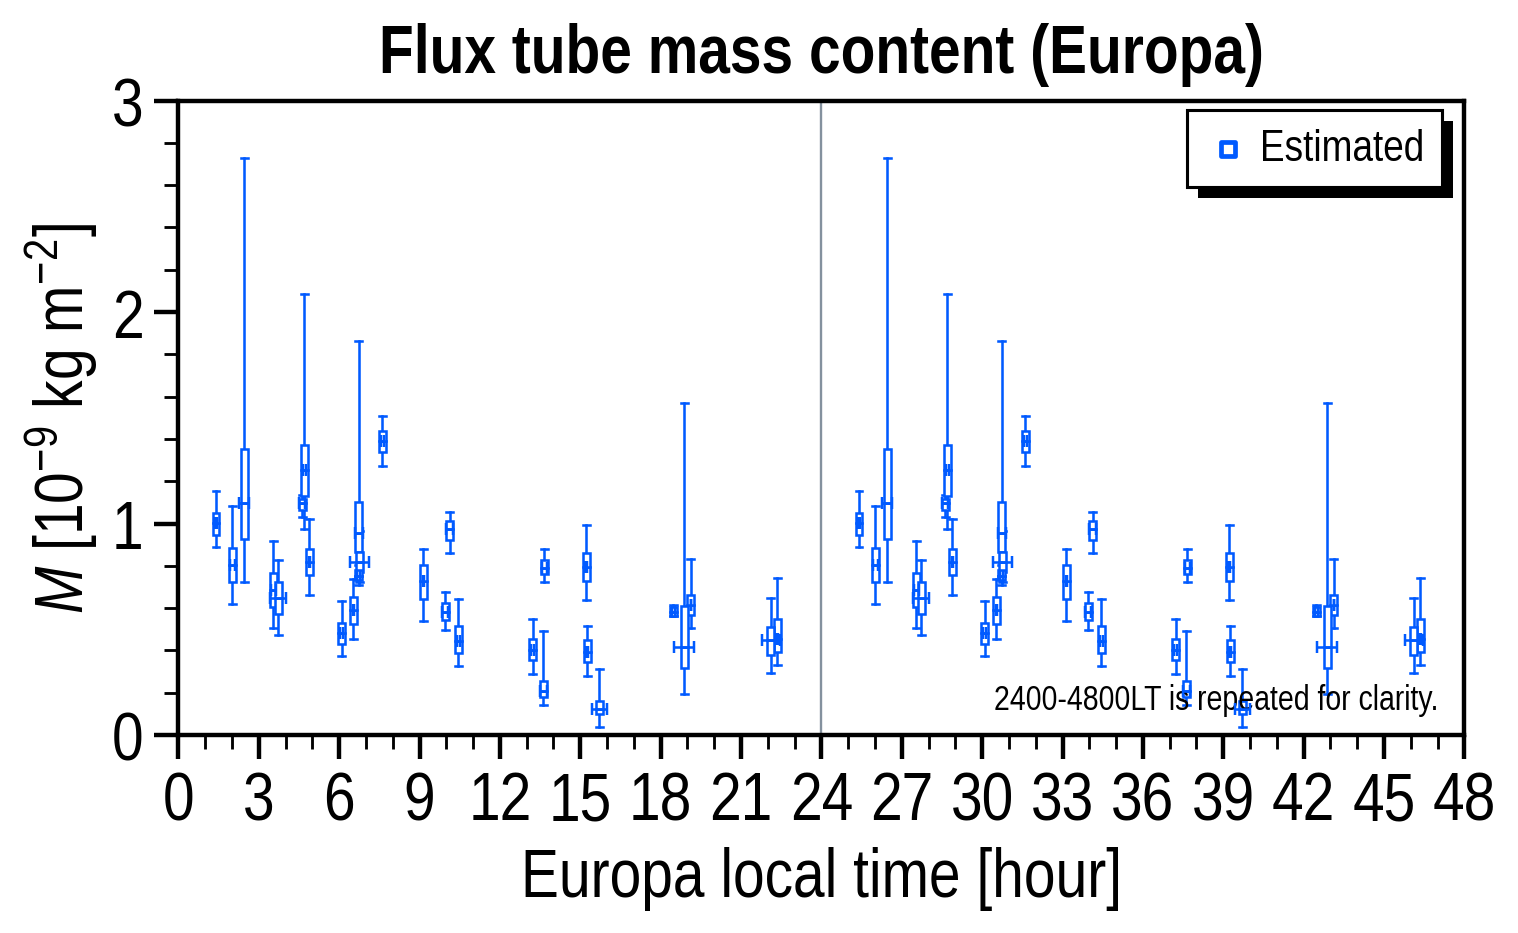

In [19]:
# %% 横軸LT(48時間) 散布図 ベストフィット付き (これが一番大事)
F = ShareXaxis()
F.fontsize = 22
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(7, 4), dpi='L')
F.initialize()

F.set_xaxis(label=target_moon+' local time [hour]',
            min=0, max=48,
            ticks=np.arange(0, 48+1, 3),
            ticklabels=np.arange(0, 48+1, 3),
            minor_num=3)
F.set_yaxis(ax_idx=0,
            label=r'$M$ [10$^{-9}$ kg m$^{-2}$]',
            min=0, max=ymax,
            ticks=ticks,
            ticklabels=ticks,
            minor_num=5)
# F.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

jj = 0
median_arr = np.zeros(len(exnum))
for ii in range(2):
    for i in range(len(exnum)):
        # %% Load the data
        exname = exdate+'_'+exnum[i]
        column_mass, chi2r, moon_et, _, _, weight = data_load(
            exname)     # [kg m-2]
        column_mass *= 1E+9  # [10^-9 kg m-2]

        # Local time
        lt_arr = np.zeros(moon_et.size)
        s3_arr = np.zeros(moon_et.size)
        for k in range(moon_et.size):
            lt_arr[k] = local_time_moon(moon_et[k], target_moon)
            _, _, _, _, _, _, s3_arr[k] = spice_moonS3(moon_et[k], target_moon)

        lt_center = ((lt_arr[0]+lt_arr[-1])/2)+24.0*ii
        lt_range = abs(lt_arr[0]-lt_arr[-1])

        q1, medians, q3 = weighted_percentile(data=column_mass,
                                              perc=[0.25, 0.5, 0.75],
                                              weights=weight)
        width = 0.26
        weighted_boxplot2(F.ax, lt_center, q1, medians, q3,
                          np.min(column_mass),
                          np.max(column_mass), width=width,
                          ec=UC.blue, lw=0.81)

        if abs(PJ_list[i]-round(PJ_list[i])) < 0.1:
            half_width = 0.41
            F.ax.errorbar(lt_center, medians,
                          xerr=np.array([[abs(lt_arr[0]+(24.0*ii)-lt_center)],
                                         [abs(lt_arr[-1]+(24.0*ii)-lt_center)]]),
                          color=UC.blue, linewidth=0.81, elinewidth=0.81,
                          capsize=5.0*half_width,
                          capthick=0.79,
                          zorder=5)

        if jj < len(exnum):
            jj += 1

        median_arr[i] = medians

# Dummy
sc = F.ax.scatter(-5, 1, s=2.5, marker='s',
                  ec=UC.blue, fc='w', lw=1.5, label='Estimated', zorder=4)

# LT=24.0
F.ax.axvline(x=24.0, color=UC.gray, linewidth=0.75)

# Repeated for clarity
F.ax.text(0.98, 0.03,
          '2400-4800LT is repeated for clarity.',
          color='k',
          horizontalalignment='right',
          verticalalignment='bottom',
          transform=F.ax.transAxes,
          fontsize=F.fontsize*0.5)

legend = F.legend(ax_idx=0,
                  bbox_to_anchor=(1.0, 1.02),
                  ncol=3, markerscale=3,
                  fontsize_scale=0.65, textcolor=True, handletextpad=0.2)
legend_shadow(fig=F.fig, ax=F.ax, legend=legend)

F.ax.set_title(r'Flux tube mass content ('+target_moon+')',
               fontsize=F.fontsize, weight='bold')
plt.show()

Min chi2: 9.12625140665715 at (array([22]), array([1]), array([34]))
Scale height [RJ]: 2.2302713697587864
Min chi2: 6.216166089400321 at (array([28]), array([0]), array([14]))
Scale height [RJ]: 1.4185324393405
Min chi2: 15.208098138362477 at (array([13]), array([0]), array([58]))
Scale height [RJ]: 4.967336364562364
Min chi2: 7.270609835981681 at (array([28]), array([0]), array([34]))
Scale height [RJ]: 2.365560014163972
Min chi2: 2.8034611173485726 at (array([17]), array([0]), array([57]))
Scale height [RJ]: 4.810137983611292
Min chi2: 3.0584903960953933 at (array([22]), array([1]), array([27]))
Scale height [RJ]: 1.8340385818200942
Min chi2: 48.953054741553686 at (array([15]), array([0]), array([57]))
Scale height [RJ]: 4.810137983611292
Min chi2: 1.6482084657884286 at (array([30]), array([2]), array([14]))
Scale height [RJ]: 1.268773985061582
Min chi2: 26.17570786925807 at (array([24]), array([2]), array([0]))
Scale height [RJ]: 0.9914837366290987
Min chi2: 68.63810204133654 at (a

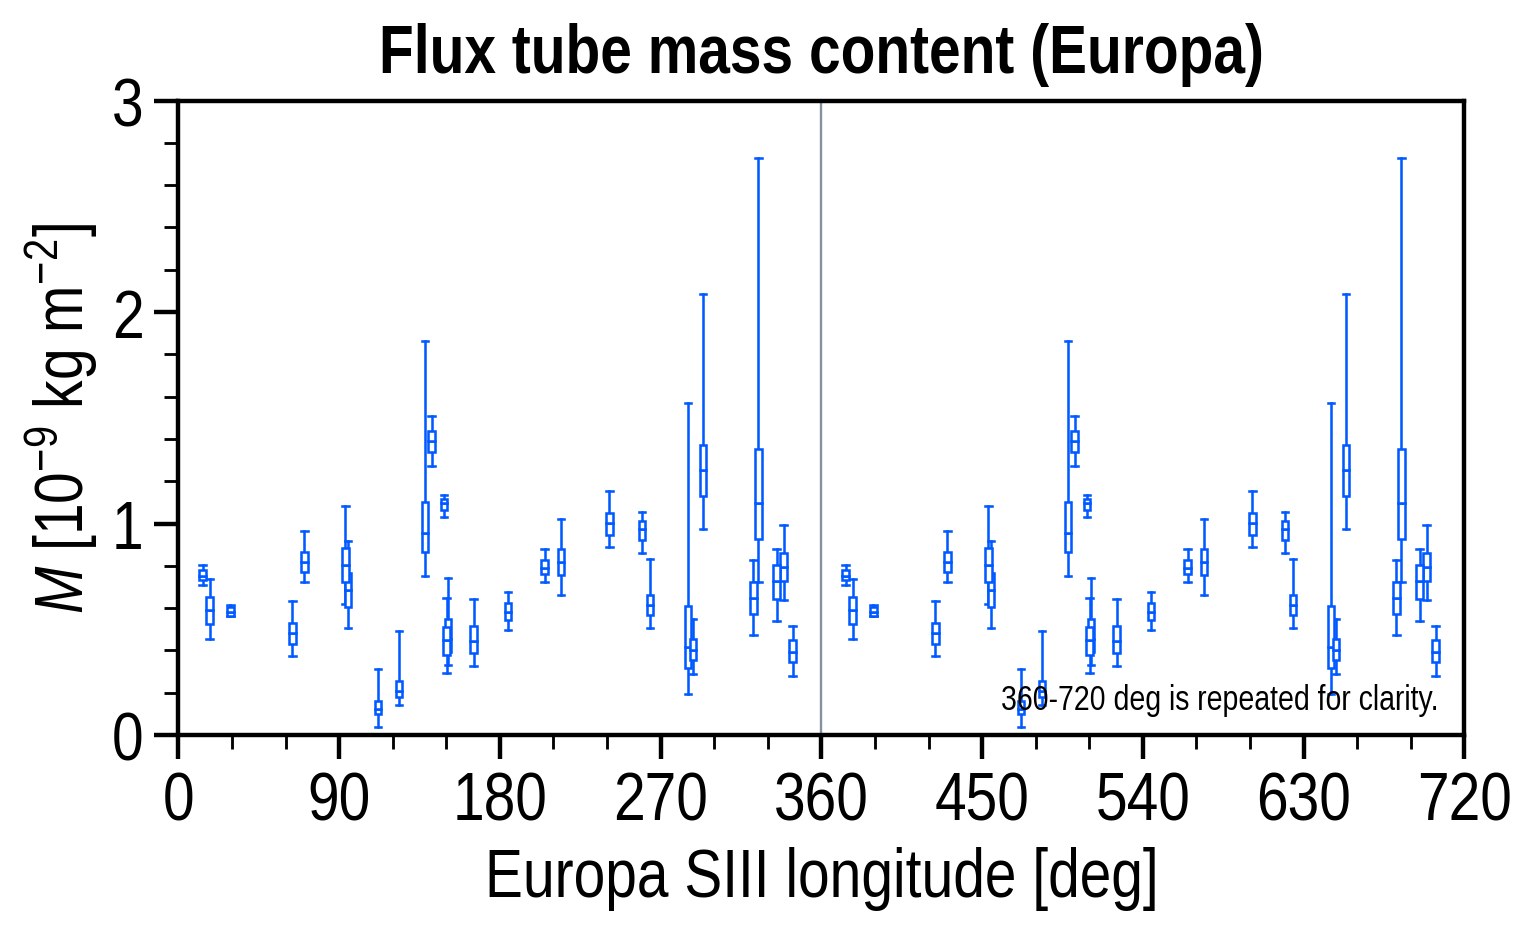

In [20]:
# %% 横軸SIII 散布図
F = ShareXaxis()
F.fontsize = 22
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(7, 4), dpi='L')
F.initialize()

F.set_xaxis(label=target_moon+' SIII longitude [deg]',
            min=0, max=720,
            ticks=np.arange(0, 720+1, 90),
            ticklabels=np.arange(0, 720+1, 90),
            minor_num=3)
F.set_yaxis(ax_idx=0,
            label=r'$M$ [10$^{-9}$ kg m$^{-2}$]',
            min=0, max=ymax,
            ticks=ticks,
            ticklabels=ticks,
            minor_num=5)
# F.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

jj = 0
median_arr = np.zeros(len(exnum))
for ii in range(2):
    for i in range(len(exnum)):
        # %% Load the data
        exname = exdate+'_'+exnum[i]
        column_mass, chi2r, moon_et, _, _, weight = data_load(
            exname)     # [kg m-2]
        column_mass *= 1E+9  # [10^-9 kg m-2]

        # Local time
        lt_arr = np.zeros(moon_et.size)
        s3_arr = np.zeros(moon_et.size)
        for k in range(moon_et.size):
            lt_arr[k] = local_time_moon(moon_et[k], target_moon)
            _, _, _, _, _, _, s3_arr[k] = spice_moonS3(moon_et[k], target_moon)

        lt_center = ((lt_arr[0]+lt_arr[-1])/2)+24.0*ii
        s3_center = ((s3_arr[0]+s3_arr[-1])/2)+360.0*ii
        lt_range = abs(s3_arr[0]-s3_arr[-1])

        q1, medians, q3 = weighted_percentile(data=column_mass,
                                              perc=[0.25, 0.5, 0.75],
                                              weights=weight)
        width = 3.70
        weighted_boxplot2(F.ax, s3_center, q1, medians, q3,
                          np.min(column_mass),
                          np.max(column_mass), width=width,
                          ec=UC.blue, lw=0.81)

        """if abs(PJ_list[i]-round(PJ_list[i])) < 0.1:
            half_width = 0.41
            F.ax.errorbar(s3_center, medians,
                          xerr=np.array([[abs(s3_arr[0]+(360.0*ii)-s3_center)],
                                         [abs(s3_arr[-1]+(360.0*ii)-s3_center)]]),
                          color=UC.blue, linewidth=0.81, elinewidth=0.81,
                          capsize=5.0*half_width,
                          capthick=0.79,
                          zorder=5)"""

        if jj < len(exnum):
            jj += 1

        median_arr[i] = medians

# Dummy
sc = F.ax.scatter(-5, 1, s=2.5, marker='s',
                  ec=UC.blue, fc='w', lw=1.5, label='3', zorder=4)

# SIII=360.0
F.ax.axvline(x=360.0, color=UC.gray, linewidth=0.75)

# Repeated for clarity
F.ax.text(0.98, 0.03,
          '360-720 deg is repeated for clarity.',
          color='k',
          horizontalalignment='right',
          verticalalignment='bottom',
          transform=F.ax.transAxes,
          fontsize=F.fontsize*0.5)

F.ax.set_title(r'Flux tube mass content ('+target_moon+')',
               fontsize=F.fontsize, weight='bold')

plt.show()

Min chi2: 9.12625140665715 at (array([22]), array([1]), array([34]))
Scale height [RJ]: 2.2302713697587864
Min chi2: 6.216166089400321 at (array([28]), array([0]), array([14]))
Scale height [RJ]: 1.4185324393405
Min chi2: 15.208098138362477 at (array([13]), array([0]), array([58]))
Scale height [RJ]: 4.967336364562364
Min chi2: 7.270609835981681 at (array([28]), array([0]), array([34]))
Scale height [RJ]: 2.365560014163972
Min chi2: 2.8034611173485726 at (array([17]), array([0]), array([57]))
Scale height [RJ]: 4.810137983611292
Min chi2: 3.0584903960953933 at (array([22]), array([1]), array([27]))
Scale height [RJ]: 1.8340385818200942
Min chi2: 48.953054741553686 at (array([15]), array([0]), array([57]))
Scale height [RJ]: 4.810137983611292
Min chi2: 1.6482084657884286 at (array([30]), array([2]), array([14]))
Scale height [RJ]: 1.268773985061582
Min chi2: 26.17570786925807 at (array([24]), array([2]), array([0]))
Scale height [RJ]: 0.9914837366290987
Min chi2: 68.63810204133654 at (a

Min chi2: 0.4323418134856346 at (array([20]), array([0]), array([31]))
Scale height [RJ]: 2.1715844282369714
Min chi2: 2.6199848270382984 at (array([29]), array([0]), array([14]))
Scale height [RJ]: 1.4185324393405
Min chi2: 200.44216757736558 at (array([14]), array([0]), array([44]))
Scale height [RJ]: 3.191500619999847
Min chi2: 6.840571869002739 at (array([25]), array([1]), array([40]))
Scale height [RJ]: 2.663292255758181
Min chi2: 3.712264712755976 at (array([23]), array([0]), array([56]))
Scale height [RJ]: 4.658221850327204
Min chi2: 34.81141613848742 at (array([22]), array([2]), array([48]))
Scale height [RJ]: 3.2325303448297333
Min chi2: 6.372013577489199 at (array([0]), array([0]), array([26]))
Scale height [RJ]: 1.8940361862156747
Min chi2: 79.13656688352107 at (array([32]), array([1]), array([9]))
Scale height [RJ]: 1.209847397113539
Min chi2: 3.612130426995619 at (array([26]), array([2]), array([6]))
Scale height [RJ]: 1.0877355325558271
Min chi2: 188.25360735016486 at (ar

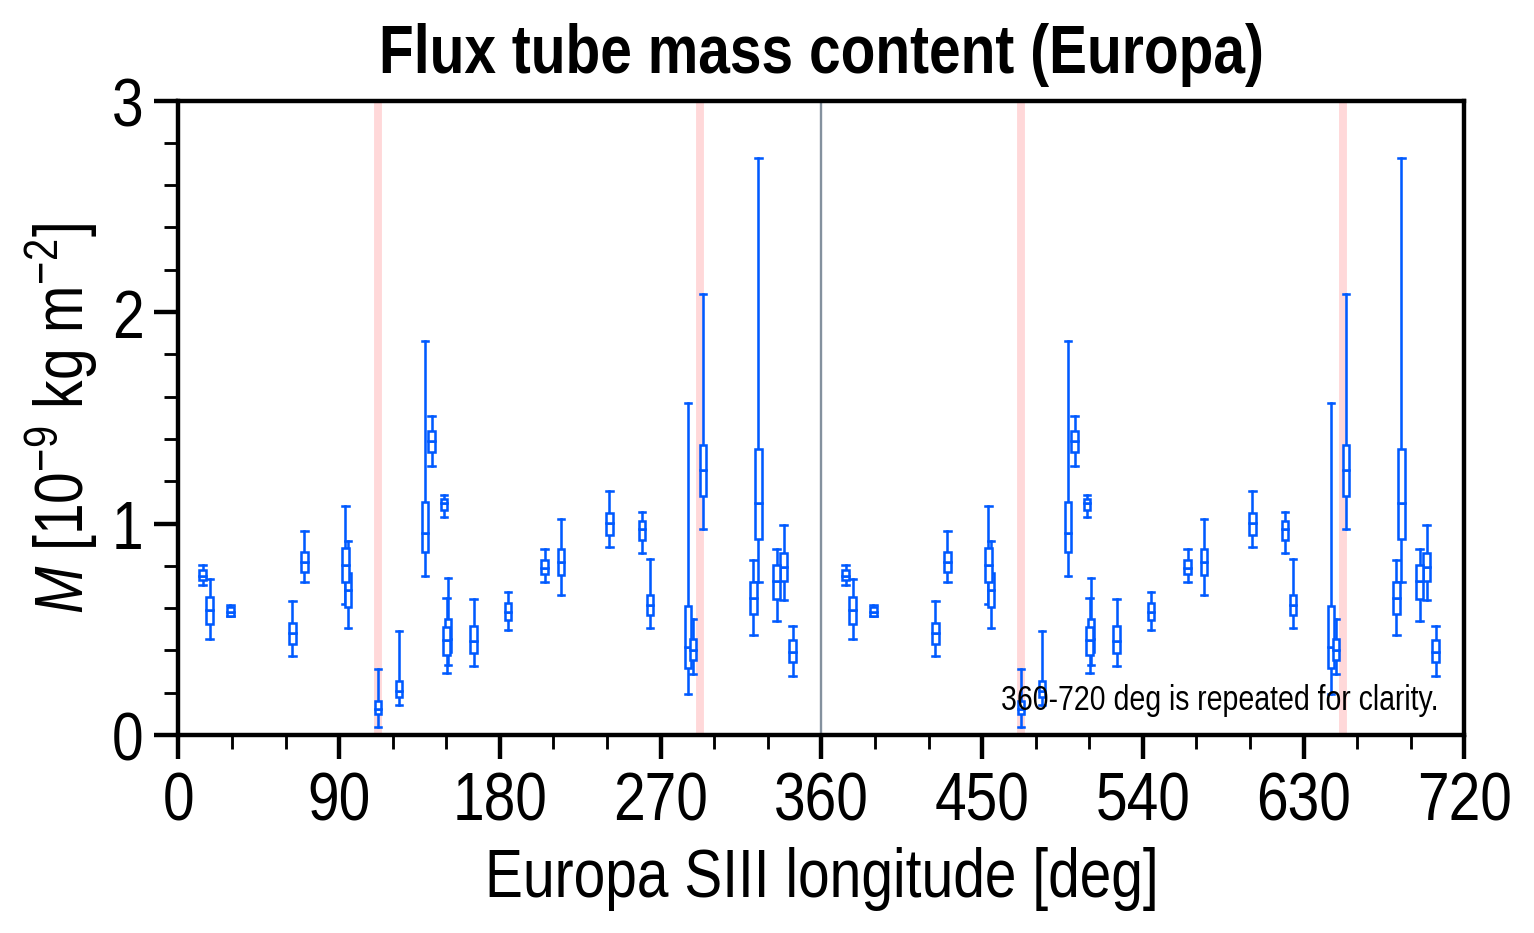

In [21]:
# %% 横軸SIII 散布図
F = ShareXaxis()
F.fontsize = 22
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(7, 4), dpi='L')
F.initialize()

F.set_xaxis(label=target_moon+' SIII longitude [deg]',
            min=0, max=720,
            ticks=np.arange(0, 720+1, 90),
            ticklabels=np.arange(0, 720+1, 90),
            minor_num=3)
F.set_yaxis(ax_idx=0,
            label=r'$M$ [10$^{-9}$ kg m$^{-2}$]',
            min=0, max=ymax,
            ticks=ticks,
            ticklabels=ticks,
            minor_num=5)
# F.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

jj = 0
median_arr = np.zeros(len(exnum))
median_error = np.zeros(len(exnum))
lt_center_arr = np.zeros(len(exnum))
s3_center_arr = np.zeros(len(exnum))
for ii in range(2):
    for i in range(len(exnum)):
        # %% Load the data
        exname = exdate+'_'+exnum[i]
        column_mass, chi2r, moon_et, _, _, weight = data_load(
            exname)     # [kg m-2]
        column_mass *= 1E+9  # [10^-9 kg m-2]

        # Local time
        lt_arr = np.zeros(moon_et.size)
        s3_arr = np.zeros(moon_et.size)
        for k in range(moon_et.size):
            lt_arr[k] = local_time_moon(moon_et[k], target_moon)
            _, _, _, _, _, _, s3_arr[k] = spice_moonS3(moon_et[k], target_moon)

        lt_center = ((lt_arr[0]+lt_arr[-1])/2)+24.0*ii
        s3_center = ((s3_arr[0]+s3_arr[-1])/2)+360.0*ii
        lt_range = abs(s3_arr[0]-s3_arr[-1])

        q1, medians, q3 = weighted_percentile(data=column_mass,
                                              perc=[0.25, 0.5, 0.75],
                                              weights=weight)
        width = 3.70
        weighted_boxplot2(F.ax, s3_center, q1, medians, q3,
                          np.min(column_mass),
                          np.max(column_mass), width=width,
                          ec=UC.blue, lw=0.81)

        """if abs(PJ_list[i]-round(PJ_list[i])) < 0.1:
            half_width = 0.41
            F.ax.errorbar(s3_center, medians,
                          xerr=np.array([[abs(s3_arr[0]+(360.0*ii)-s3_center)],
                                         [abs(s3_arr[-1]+(360.0*ii)-s3_center)]]),
                          color=UC.blue, linewidth=0.81, elinewidth=0.81,
                          capsize=5.0*half_width,
                          capthick=0.79,
                          zorder=5)"""

        if jj < len(exnum):
            jj += 1

        lt_center_arr[i] = lt_center
        s3_center_arr[i] = s3_center
        median_arr[i] = medians
        median_error[i] = q3-q1
        if q3-q1 == 0.:
            median_error[i] = 0.001

# 相関係数
correlation, pvalue = spearmanr(median_arr, s3_center_arr)
print('Correlation coeff: ', correlation)

# t検定
n_data = median_arr.size
t_value = correlation*math.sqrt((n_data-2)/(1-correlation**2))
print('t value:', t_value)
print('n_data:', n_data)

# 両側p値
p_two_sided = 2*t.cdf(t_value, n_data-2)
print('p value:', p_two_sided)  # 相関係数ここまで

# Dummy
sc = F.ax.scatter(-5, 1, s=2.5, marker='s',
                  ec=UC.blue, fc='w', lw=1.5, label='3', zorder=4)

# SIII=360.0
F.ax.axvline(x=360.0, color=UC.gray, linewidth=0.75)

# Plasma sheet crossing
for i in range(4):
    F.ax.axvline(x=112.0+180.0*i, color=UC.pink,
                 alpha=0.3, linewidth=2.5, zorder=0.01)

# Repeated for clarity
F.ax.text(0.98, 0.03,
          '360-720 deg is repeated for clarity.',
          color='k',
          horizontalalignment='right',
          verticalalignment='bottom',
          transform=F.ax.transAxes,
          fontsize=F.fontsize*0.5)

F.ax.set_title(r'Flux tube mass content ('+target_moon+')',
               fontsize=F.fontsize, weight='bold')

plt.show()

$\textcolor{yellow}{テストではここから上をRunする}$

Min chi2: 9.12625140665715 at (array([22]), array([1]), array([34]))
Scale height [RJ]: 2.2302713697587864
Min chi2: 6.216166089400321 at (array([28]), array([0]), array([14]))
Scale height [RJ]: 1.4185324393405
Min chi2: 15.208098138362477 at (array([13]), array([0]), array([58]))
Scale height [RJ]: 4.967336364562364
Min chi2: 7.270609835981681 at (array([28]), array([0]), array([34]))
Scale height [RJ]: 2.365560014163972
Min chi2: 2.8034611173485726 at (array([17]), array([0]), array([57]))
Scale height [RJ]: 4.810137983611292
Min chi2: 3.0584903960953933 at (array([22]), array([1]), array([27]))
Scale height [RJ]: 1.8340385818200942
Min chi2: 48.953054741553686 at (array([15]), array([0]), array([57]))
Scale height [RJ]: 4.810137983611292
Min chi2: 1.6482084657884286 at (array([30]), array([2]), array([14]))
Scale height [RJ]: 1.268773985061582
Min chi2: 26.17570786925807 at (array([24]), array([2]), array([0]))
Scale height [RJ]: 0.9914837366290987
Min chi2: 68.63810204133654 at (a

Min chi2: 84.79745414714108 at (array([14]), array([0]), array([59]))
Scale height [RJ]: 5.129990253402048
Min chi2: 69.69786216874037 at (array([17]), array([0]), array([59]))
Scale height [RJ]: 5.129990253402048
Min chi2: 2.9755200115158127 at (array([16]), array([0]), array([59]))
Scale height [RJ]: 5.129990253402048
Min chi2: 1.776259431651573 at (array([15]), array([1]), array([39]))
Scale height [RJ]: 2.5843650120224058
Min chi2: 19.78425176183982 at (array([34]), array([0]), array([28]))
Scale height [RJ]: 1.9986086848032687
Min chi2: 31.50768607025124 at (array([27]), array([2]), array([37]))
Scale height [RJ]: 2.3099196156428383
Min chi2: 1.0323816486123791 at (array([27]), array([0]), array([38]))
Scale height [RJ]: 2.6604036816623915
Min chi2: 1.0370903656358434 at (array([26]), array([0]), array([32]))
Scale height [RJ]: 2.2338131668178125
Min chi2: 9.12625140665715 at (array([22]), array([1]), array([34]))
Scale height [RJ]: 2.2302713697587864
Min chi2: 6.216166089400321 a

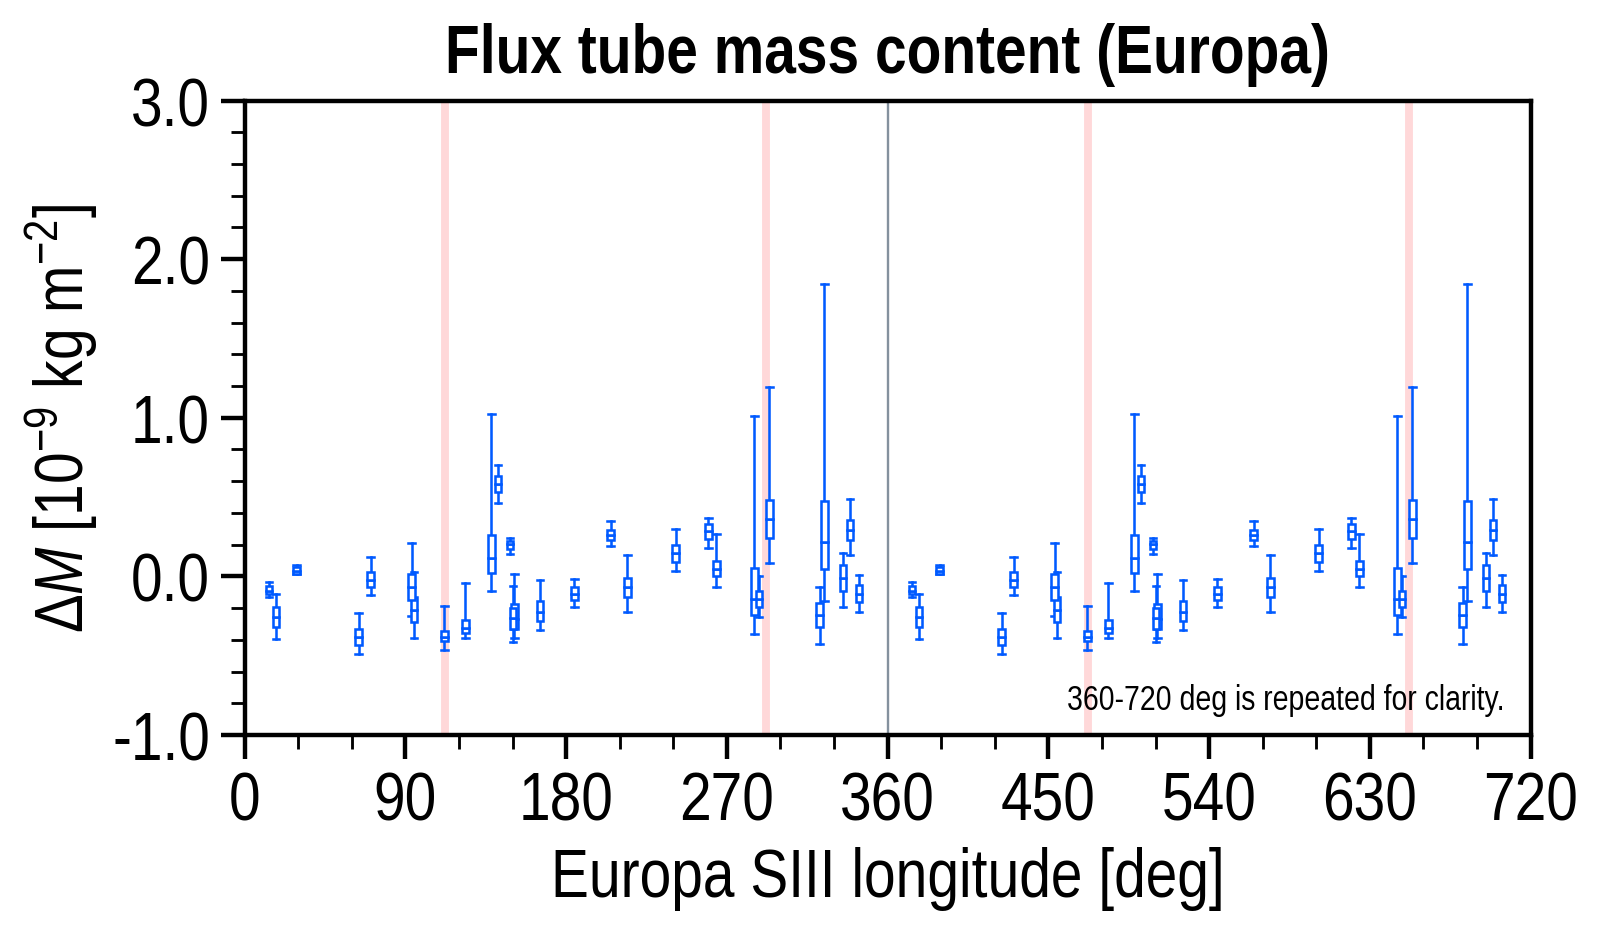

In [22]:
# %% 横軸SIII 散布図
F = ShareXaxis()
F.fontsize = 22
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(7, 4), dpi='L')
F.initialize()

F.set_xaxis(label=target_moon+' SIII longitude [deg]',
            min=0, max=720,
            ticks=np.arange(0, 720+1, 90),
            ticklabels=np.arange(0, 720+1, 90),
            minor_num=3)
F.set_yaxis(ax_idx=0,
            label=r'$\Delta M$ [10$^{-9}$ kg m$^{-2}$]',
            min=-15, max=20,
            ticks=np.arange(-15, 20+1, 5),
            ticklabels=np.arange(-15, 20+1, 5),
            minor_num=5)

if target_moon == 'Europa':
    F.set_yaxis(ax_idx=0,
                label=r'$\Delta M$ [10$^{-9}$ kg m$^{-2}$]',
                min=-1, max=3,
                ticks=np.arange(-1, 3+1, 1),
                ticklabels=np.arange(-1, 3+1, 1),
                minor_num=5)
    F.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
elif target_moon == 'Ganymede':
    F.set_yaxis(ax_idx=0,
                label=r'$\Delta M$ [10$^{-9}$ kg m$^{-2}$]',
                min=-0.1, max=0.2,
                ticks=np.arange(-0.1, 0.2+0.01, 0.05),
                ticklabels=np.round(np.arange(-0.1, 0.2+0.01, 0.05), 2),
                minor_num=5)

jj = 0
median_arr = np.zeros(len(exnum))
median_error = np.zeros(len(exnum))
lt_center_arr = np.zeros(len(exnum))
s3_center_arr = np.zeros(len(exnum))
median_arr = np.zeros(len(exnum))
for ii in range(2):
    for i in range(len(exnum)):
        # %% Load the data
        exname = exdate+'_'+exnum[i]
        column_mass, chi2r, moon_et, _, _, weight = data_load(
            exname)     # [kg m-2]
        column_mass *= 1E+9  # [10^-9 kg m-2]

        # Local time
        lt_arr = np.zeros(moon_et.size)
        s3_arr = np.zeros(moon_et.size)
        for k in range(moon_et.size):
            lt_arr[k] = local_time_moon(moon_et[k], target_moon)
            _, _, _, _, _, _, s3_arr[k] = spice_moonS3(moon_et[k], target_moon)

        lt_center = ((lt_arr[0]+lt_arr[-1])/2)+24.0*ii
        s3_center = ((s3_arr[0]+s3_arr[-1])/2)+360.0*ii
        lt_range = abs(s3_arr[0]-s3_arr[-1])

        y_fit = fit_func2(popt, lt_center)

        q1, medians, q3 = weighted_percentile(data=column_mass-y_fit,
                                              perc=[0.25, 0.5, 0.75],
                                              weights=weight)
        width = 3.70
        weighted_boxplot2(F.ax, s3_center, q1, medians, q3,
                          np.min(column_mass)-y_fit,
                          np.max(column_mass)-y_fit, width=width,
                          ec=UC.blue, lw=0.81)

        if jj < len(exnum):
            jj += 1

        lt_center_arr[i] = lt_center
        s3_center_arr[i] = s3_center
        median_arr[i] = medians
        median_error[i] = q3-q1
        if q3-q1 == 0.:
            median_error[i] = 0.001

# 相関係数
correlation, pvalue = spearmanr(median_arr, s3_center_arr)
print('Correlation coeff: ', correlation)

# t検定
n_data = median_arr.size
t_value = correlation*math.sqrt((n_data-2)/(1-correlation**2))
print('t value:', t_value)
print('n_data:', n_data)

# 両側p値
p_two_sided = 2*t.cdf(t_value, n_data-2)
print('p value:', p_two_sided)  # 相関係数ここまで

# Dummy
sc = F.ax.scatter(-5, 1, s=2.5, marker='s',
                  ec=UC.blue, fc='w', lw=1.5, label='3', zorder=4)

# SIII=360.0
F.ax.axvline(x=360.0, color=UC.gray, linewidth=0.75)

# Plasma sheet crossing
for i in range(4):
    F.ax.axvline(x=112.0+180.0*i, color=UC.pink,
                 alpha=0.3, linewidth=2.5, zorder=0.01)

# Repeated for clarity
F.ax.text(0.98, 0.03,
          '360-720 deg is repeated for clarity.',
          color='k',
          horizontalalignment='right',
          verticalalignment='bottom',
          transform=F.ax.transAxes,
          fontsize=F.fontsize*0.5)

F.ax.set_title(r'Flux tube mass content ('+target_moon+')',
               fontsize=F.fontsize, weight='bold')

plt.show()

$\textcolor{yellow}{\text{Ganymede Peak LT Fixed}}$

In [23]:
# %% Ganymedeフィッティング用の三角関数
c_ave = np.average([3.70, 3.85])


def fit_func2_Ga(params, x):
    a, d = params
    c = c_ave
    return a * np.cos(2*np.pi*(x-c)/24.0) + d

Phase LT is fixed at: 3.7750000000000004
Best fit: [0.19779598 0.69841555]
Error: [0.05094528 0.03903446]
lmean: 0.5006326333596909 0.8961895558357049
cov_beta: [[0.00259542 0.00012566]
 [0.00012566 0.00152369]]
res_var: 13.941822996861479
Check: [0.05094528 0.03903446]
Min chi2: 9.12625140665715 at (array([22]), array([1]), array([34]))
Scale height [RJ]: 2.2302713697587864
Min chi2: 6.216166089400321 at (array([28]), array([0]), array([14]))
Scale height [RJ]: 1.4185324393405
Min chi2: 15.208098138362477 at (array([13]), array([0]), array([58]))
Scale height [RJ]: 4.967336364562364
Min chi2: 7.270609835981681 at (array([28]), array([0]), array([34]))
Scale height [RJ]: 2.365560014163972
Min chi2: 2.8034611173485726 at (array([17]), array([0]), array([57]))
Scale height [RJ]: 4.810137983611292
Min chi2: 3.0584903960953933 at (array([22]), array([1]), array([27]))
Scale height [RJ]: 1.8340385818200942
Min chi2: 48.953054741553686 at (array([15]), array([0]), array([57]))
Scale height [

Min chi2: 68.63810204133654 at (array([15]), array([0]), array([59]))
Scale height [RJ]: 5.129990253402048
Min chi2: 0.5181228245857631 at (array([35]), array([0]), array([2]))
Scale height [RJ]: 1.1407911790168306
Min chi2: 0.4323418134856346 at (array([20]), array([0]), array([31]))
Scale height [RJ]: 2.1715844282369714
Min chi2: 2.6199848270382984 at (array([29]), array([0]), array([14]))
Scale height [RJ]: 1.4185324393405
Min chi2: 200.44216757736558 at (array([14]), array([0]), array([44]))
Scale height [RJ]: 3.191500619999847
Min chi2: 6.840571869002739 at (array([25]), array([1]), array([40]))
Scale height [RJ]: 2.663292255758181
Min chi2: 3.712264712755976 at (array([23]), array([0]), array([56]))
Scale height [RJ]: 4.658221850327204
Min chi2: 34.81141613848742 at (array([22]), array([2]), array([48]))
Scale height [RJ]: 3.2325303448297333
Min chi2: 6.372013577489199 at (array([0]), array([0]), array([26]))
Scale height [RJ]: 1.8940361862156747
Min chi2: 79.13656688352107 at (a

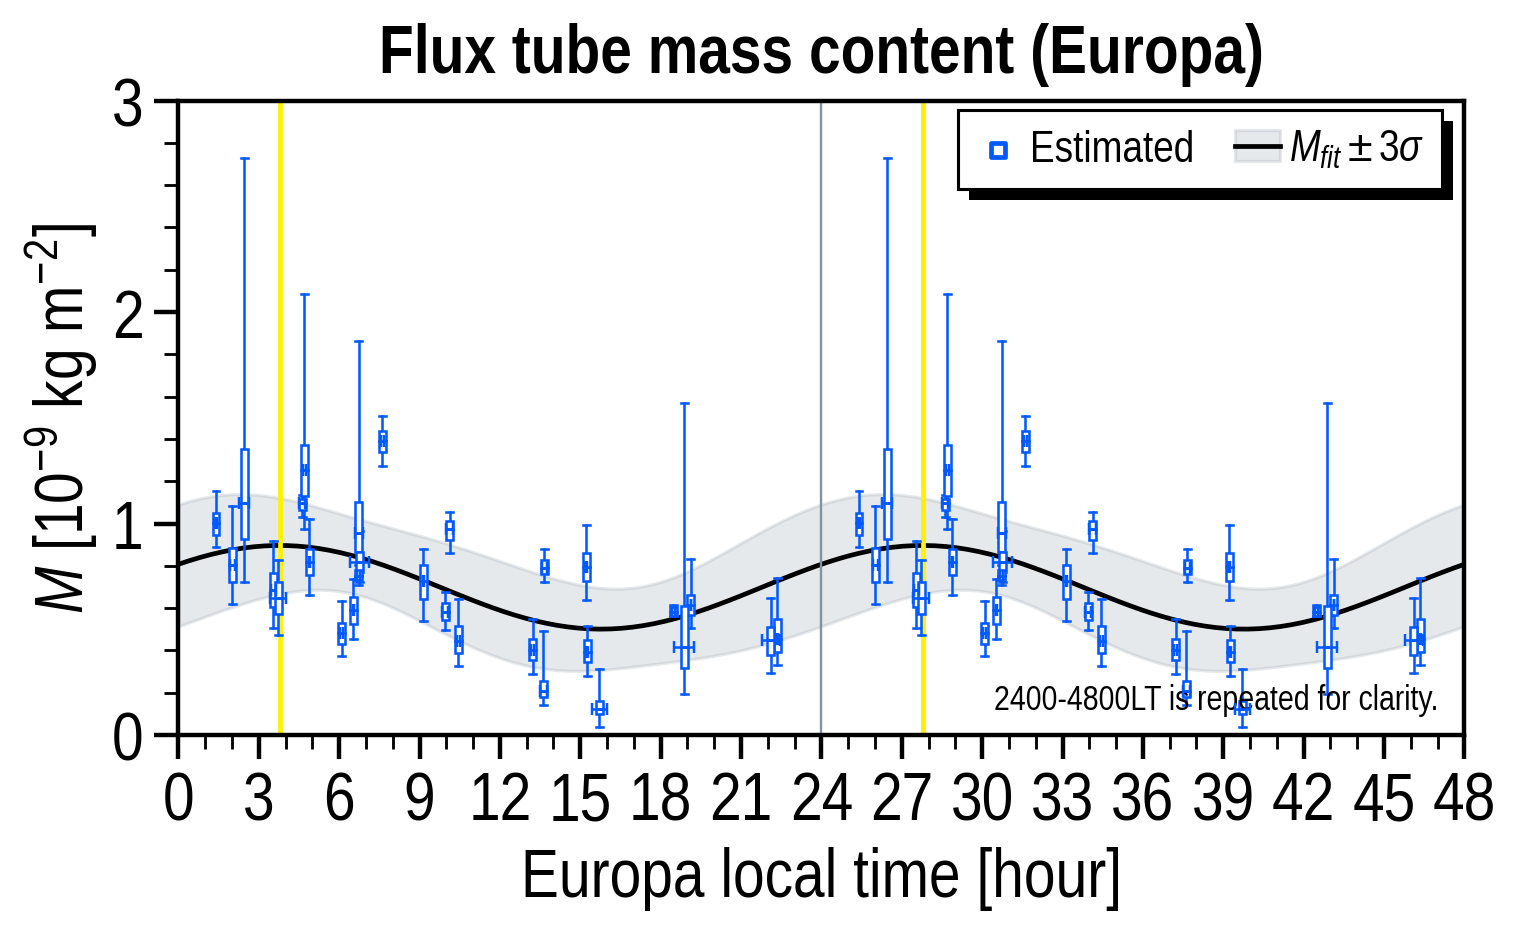

In [24]:
# %% 横軸LT(48時間) 散布図 ベストフィット付き (これが一番大事)
F = ShareXaxis()
F.fontsize = 22
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(7, 4), dpi='L')
F.initialize()

F.set_xaxis(label=target_moon+' local time [hour]',
            min=0, max=48,
            ticks=np.arange(0, 48+1, 3),
            ticklabels=np.arange(0, 48+1, 3),
            minor_num=3)
F.set_yaxis(ax_idx=0,
            label=r'$M$ [10$^{-9}$ kg m$^{-2}$]',
            min=0, max=ymax,
            ticks=ticks,
            ticklabels=ticks,
            minor_num=5)
# F.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

x_arr = medians_x
y_arr = medians_arr
x_err_arr = medians_x_err/2
y_err_arr = y_sigma_arr

sort = np.argsort(x_arr)[::-1]
x_arr, y_arr, x_err_arr, y_err_arr = x_arr[sort], y_arr[sort], x_err_arr[sort], y_err_arr[sort]

# ODR 用データとモデルの設定
data = RealData(x_arr, y_arr, sx=x_err_arr, sy=y_err_arr)
model = Model(fit_func2_Ga)

# ODR 実行
odr_instance = ODR(data, model, beta0=[1.0, 1.0])
output = odr_instance.run()

# フィッティング結果
popt = output.beta
perr = output.sd_beta  # *np.sqrt(output.res_var)
cov = output.cov_beta*output.res_var

# ベストフィット
nstd = 3  # 95% 信頼区間
x_fit = np.linspace(0.0, 48.0, 120)
y_fit = fit_func2_Ga(popt, x_fit)
lmean, = F.ax.plot(x_fit, y_fit, zorder=0.1, label='1', color='k')
print('Phase LT is fixed at:', c_ave)
print('Best fit:', popt)
print('Error:', perr)
print('lmean:', np.min(y_fit), np.max(y_fit))
print('cov_beta:', cov)
print('res_var:', output.res_var)
print('Check:', np.sqrt(np.diag(output.cov_beta*output.res_var)))

# 予測区間の計算
if target_moon == 'Ganymede':
    # ヤコビアンの計算
    J_f0 = np.cos(np.pi*(x_fit-c_ave)/12.0)
    J_f1 = 1.0
    J_f = np.array([J_f0, J_f1])
    sigma_f = np.sqrt((J_f@cov)@J_f.T)
    y_fit_up = y_fit + 3.0*sigma_f
    y_fit_dw = y_fit - 3.0*sigma_f

lsigma = F.ax.fill_between(x_fit, y_fit_up, y_fit_dw,
                           color=UC.gray, alpha=0.2,
                           label='2',
                           zorder=0.01)


jj = 0
median_arr = np.zeros(len(exnum))
median_error = np.zeros(len(exnum))
lt_center_arr = np.zeros(len(exnum))
for ii in range(2):
    for i in range(len(exnum)):
        # %% Load the data
        exname = exdate+'_'+exnum[i]
        column_mass, chi2r, moon_et, _, _, weight = data_load(
            exname)     # [kg m-2]
        column_mass *= 1E+9  # [10^-9 kg m-2]

        # Local time
        lt_arr = np.zeros(moon_et.size)
        s3_arr = np.zeros(moon_et.size)
        for k in range(moon_et.size):
            lt_arr[k] = local_time_moon(moon_et[k], target_moon)
            _, _, _, _, _, _, s3_arr[k] = spice_moonS3(moon_et[k], target_moon)

        lt_center = ((lt_arr[0]+lt_arr[-1])/2)+24.0*ii
        lt_range = abs(lt_arr[0]-lt_arr[-1])

        q1, medians, q3 = weighted_percentile(data=column_mass,
                                              perc=[0.25, 0.5, 0.75],
                                              weights=weight)
        width = 0.26
        weighted_boxplot2(F.ax, lt_center, q1, medians, q3,
                          np.min(column_mass),
                          np.max(column_mass), width=width,
                          ec=UC.blue, lw=0.81)

        if abs(PJ_list[i]-round(PJ_list[i])) < 0.1:
            half_width = 0.41
            F.ax.errorbar(lt_center, medians,
                          xerr=np.array([[abs(lt_arr[0]+(24.0*ii)-lt_center)],
                                         [abs(lt_arr[-1]+(24.0*ii)-lt_center)]]),
                          color=UC.blue, linewidth=0.81, elinewidth=0.81,
                          capsize=5.0*half_width,
                          capthick=0.79,
                          zorder=5)

        if jj < len(exnum):
            jj += 1

        lt_center_arr[i] = lt_center
        median_arr[i] = medians
        median_error[i] = q3-q1
        if q3-q1 == 0.:
            median_error[i] = 0.001

# 相関係数
correlation, pvalue = spearmanr(median_arr, lt_center_arr)
print('Correlation coeff: ', correlation)

# t検定
n_data = median_arr.size
t_value = correlation*math.sqrt((n_data-2)/(1-correlation**2))
print('t value:', t_value)
print('n_data:', n_data)

# 両側p値
p_two_sided = 2*t.cdf(t_value, n_data-2)
print('p value:', p_two_sided)  # 相関係数ここまで

# Dummy
sc = F.ax.scatter(-5, 1, s=2.5, marker='s',
                  ec=UC.blue, fc='w', lw=1.5, label='3', zorder=4)

# LT=24.0
F.ax.axvline(x=24.0, color=UC.gray, linewidth=0.75)
F.ax.axvline(x=c_ave, color=UC.yellow, linewidth=1.5, zorder=0.1)
F.ax.axvline(x=c_ave+24.0, color=UC.yellow, linewidth=1.5, zorder=0.1)

# Repeated for clarity
F.ax.text(0.98, 0.03,
          '2400-4800LT is repeated for clarity.',
          color='k',
          horizontalalignment='right',
          verticalalignment='bottom',
          transform=F.ax.transAxes,
          fontsize=F.fontsize*0.5)

handles = [sc, (lsigma, lmean)]
legend = F.legend(ax_idx=0,
                  handles=handles,
                  labels=['Estimated', r'$M_{fit} \pm 3\sigma$'],
                  bbox_to_anchor=(1.0, 1.02),
                  ncol=3, markerscale=3,
                  fontsize_scale=0.65, textcolor=True, handletextpad=0.2)
legend_shadow(fig=F.fig, ax=F.ax, legend=legend)

F.ax.set_title(r'Flux tube mass content ('+target_moon+')',
               fontsize=F.fontsize, weight='bold')

plt.show()